<a href="https://colab.research.google.com/github/wastedfoodnsf/RECIPES/blob/main/Modeling_metrics_prototype_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This prototype model is a simplified version of a techno-economic optimization model developed by Shahid and Hittinger, 2021. The techno-economic model by Shahid and Hittinger, 2021 determines the optimal way of directing commercial food waste and manure to different waste treatment facilities at the lowest system cost. In addition, the framework constitutes economic and emissions assessment models to determine the cost, energy generation, and offset emissions.

The prototype model applies a simple optimization model to prevent food waste through consumer education and allocate food waste into two types of food waste management facilities: anaerobic digestion (AD) and composting in three counties. The model determines the optimal amount of food waste allocated to each alternative considering different decision criteria: cost, sustainability, and equity.

Shahid, K., Hittinger, E., 2021. Techno-economic optimization of food waste diversion to treatment facilities to determine cost effectiveness of policy incentives. Journal of Cleaner Production 279, 122634. https://doi.org/10.1016/j.jclepro.2020.122634

Copyright <2024> <Multiscale RECIPES (Resilient, Equitable, and Circular Innovations with Partnership and Education Synergies) for Sustainable Food Systems>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Importing packages and installing solvers

In [ ]:
#Import matplotlib for graphics, numpy for mathematical operations, and math for mathematical functions
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

#Importing pyomo and optimization solvers
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

from pyomo.environ import *


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00


# Parameters

In [ ]:
# Amount of food waste to be treated or targeted in a county, tons
tot_food_waste = {'County A': 5000, 'County B': 2000, 'County C': 3000}

# Distance between food waste source and treatment facility, miles
distance = {'County A': 30, 'County B': 15, 'County C': 20}
diversion_distance = 50

# Emissions reductions rate (MT CO2 eq/ton) for different food waste management techniques
emissions_rate = {'AD': -0.093694885361552, 'Compost': -0.12, 'Education': -3.66, 'Landfill': 0.5}

# Baseline case assumes 97% waste goes to landfill and 3% of waste is composted. Emissions reduction potential of the different treatment facilities is estimated with reference to the baseline case.
baseline_allocation = {'Landfill': 0.97, 'Compost': 0.03}

# Energy use impact rate (million BTU/ton) for different food waste management techniques
energy_rate = {'AD': -0.36, 'Compost': 0.73, 'Education': -14.56, 'Landfill': 0}

population = {'County A': 1050000, 'County B': 950000, 'County C': 850000}

# Sub group population, % - low income (subgroup 1), medium income (subgroup 2), high income (subgroup 3)
sub_group_1_pct = {'County A': 0.591, 'County B': 0.272, 'County C': 0.588}
sub_group_2_pct = {'County A': 0.204, 'County B': 0.641, 'County C': 0.313}
sub_group_3_pct = {'County A': 0.205, 'County B': 0.087, 'County C': 0.099}

#Share of food waste (SFW) by income (Calories wasted/Calories available)
SFW = {'Low_income': 0.08, 'Medium_income': 0.19, 'High_income': 0.31}

discount_rate = 0.08
life_span_yr = 20
capcost_coef_AD = 603
capcost_coef_compost = 91
capcost_coef_nl = 0.5
annualcost_coef_edu = 38
fixed_cost_rate = 0.05
transportation_cost_rate = 0.25
var_cost_rate_AD = 0.55
var_cost_rate_compost = 20
biogas_rate = 109.36
electricity_rate = 2.48
revenue_rate_AD = 5.5
compost_mass_reduction_rate = 0.2
revenue_rate_compost = 35


# Section 1: Minimize net cost
This section of the code minimizes the net cost of food waste allocation to different food waste management alternatives.
Net Cost = Total Cost(i,j) - Total Revenue (i,j), where i - county (County A, County B, County C) and j - waste management (AD, compost) and prevention (education).
Total cost is the sum of capital, operating (fixed and variable), and transportation costs and total revenue is the sum of revenues from electricity and compost sales.

In [ ]:
################################################################################
# Minimize net cost model
################################################################################
model_opt_net_cost = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_net_cost.County = Set(initialize = ['County A', 'County B', 'County C'])
model_opt_net_cost.Facility = Set (initialize = ['AD', 'Compost', 'Education'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_net_cost.allocation = Var(model_opt_net_cost.County, model_opt_net_cost.Facility, domain=NonNegativeReals, initialize=0)

# Capacity at each treatment facility within each county is the product of ratio of food waste allocated to the treatment facility with the amount of food waste in that county, tons
capacity_net_cost = {}
for i in model_opt_net_cost.County:
    for j in model_opt_net_cost.Facility:
        capacity_net_cost[i,j] = model_opt_net_cost.allocation[i,j] * tot_food_waste[i]

# Capital, discounted annual capital, fixed, transportation, and variable costs and revenue
cap_cost_net_cost = {}
annual_cap_cost_net_cost = {}
fixed_cost_net_cost = {}
transportation_cost_net_cost = {}
biogas_net_cost = {}
electricity_net_cost = {}
variable_cost_net_cost = {}
revenue_net_cost = {}
for i in model_opt_net_cost.County:
    cap_cost_net_cost[i,'AD'] = capcost_coef_AD*capacity_net_cost[i,'AD'] + capcost_coef_nl*capacity_net_cost[i,'AD']**2
    cap_cost_net_cost[i,'Compost'] = capcost_coef_compost*capacity_net_cost[i,'Compost'] + capcost_coef_nl*capacity_net_cost[i,'Compost']**2
    cap_cost_net_cost[i, 'Education'] = 0
    annual_cap_cost_net_cost[i,'AD'] = cap_cost_net_cost[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_net_cost[i,'Compost'] = cap_cost_net_cost[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_net_cost[i,'Education'] = annualcost_coef_edu*capacity_net_cost[i,'Education'] + capacity_net_cost[i,'Education']**2
    fixed_cost_net_cost[i,'AD'] = fixed_cost_rate*annual_cap_cost_net_cost[i,'AD']
    fixed_cost_net_cost[i,'Compost'] = fixed_cost_rate*annual_cap_cost_net_cost[i,'Compost']
    fixed_cost_net_cost[i,'Education'] = 0
    transportation_cost_net_cost[i,'AD'] = capacity_net_cost[i,'AD'] * transportation_cost_rate * distance[i]
    transportation_cost_net_cost[i,'Compost'] = capacity_net_cost[i,'Compost'] * transportation_cost_rate * distance[i]
    transportation_cost_net_cost[i,'Education'] = 0
    biogas_net_cost[i,'AD'] = biogas_rate*capacity_net_cost[i,'AD']
    electricity_net_cost[i,'AD'] = electricity_rate*biogas_net_cost[i,'AD']
    variable_cost_net_cost[i,'AD'] = var_cost_rate_AD*electricity_net_cost[i,'AD']/100
    revenue_net_cost[i,'AD'] = revenue_rate_AD*electricity_net_cost[i,'AD']/100
    variable_cost_net_cost[i,'Compost'] = var_cost_rate_compost*capacity_net_cost[i,'Compost']
    revenue_net_cost[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_net_cost[i,'Compost']
    variable_cost_net_cost[i,'Education'] = 0
    revenue_net_cost[i,'Education'] = 0

#####################################################################################
# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_net_cost.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_net_cost.County:
    for j in model_opt_net_cost.Facility:
        emissions_avoided[i,j] = capacity_net_cost[i,j] * emissions_rate[j]

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_net_cost = {}
for i in model_opt_net_cost.County:
    Net_emissions_avoided_net_cost[i] = sum(emissions_avoided[i,j] for j in model_opt_net_cost.Facility) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
Total_net_emissions_avoided_net_cost = {}
Total_net_emissions_avoided_net_cost = sum(Net_emissions_avoided_net_cost[i] for i in model_opt_net_cost.County)

# Total emissions
Total_emissions_net_cost = sum(emissions_avoided[i,j] for i in model_opt_net_cost.County for j in model_opt_net_cost.Facility) + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_net_cost.County)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_net_cost.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_net_cost.County:
    for j in model_opt_net_cost.Facility:
        energy[i,j] = capacity_net_cost[i,j] * energy_rate[j]

# Net energy savings in each county
Net_energy_net_cost = {}
for i in model_opt_net_cost.County:
    Net_energy_net_cost[i] = sum(energy[i,j] for j in model_opt_net_cost.Facility) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
Total_net_energy_net_cost = {}
Total_net_energy_net_cost = sum(Net_energy_net_cost[i] for i in model_opt_net_cost.County)

# Total energy savings
Net_energy_saving_net_cost = -(sum(energy[i,j] for i in model_opt_net_cost.County for j in model_opt_net_cost.Facility) - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_net_cost.County))

#############################################################################################
# Per-capita emission reductions and cost across two population subgroups in each county
sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_net_cost = {}
Pc_emissions_impact_sg2_net_cost = {}
Pc_emissions_impact_sg3_net_cost = {}
for i in model_opt_net_cost.County:
    Pc_emissions_impact_sg1_net_cost[i] = -Net_emissions_avoided_net_cost[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_net_cost[i] = -Net_emissions_avoided_net_cost[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_net_cost[i] = -Net_emissions_avoided_net_cost[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_net_cost = {}
for i in model_opt_net_cost.County:
    County_netcost_net_cost[i] = sum(annual_cap_cost_net_cost[i,j] + fixed_cost_net_cost[i,j] + transportation_cost_net_cost[i,j] + \
                                        variable_cost_net_cost[i,j] for j in model_opt_net_cost.Facility)

Pc_netcost_sg1_net_cost = {}
Pc_netcost_sg2_net_cost = {}
Pc_netcost_sg3_net_cost = {}
for i in model_opt_net_cost.County:
    Pc_netcost_sg1_net_cost[i] = County_netcost_net_cost[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_net_cost[i] = County_netcost_net_cost[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_net_cost[i] = County_netcost_net_cost[i]*0.31/sub_group_3_popn[i]

####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_net_cost = sum(Pc_emissions_impact_sg1_net_cost[i] + Pc_emissions_impact_sg2_net_cost[i] + Pc_emissions_impact_sg3_net_cost[i] for i in model_opt_net_cost.County)/9
sdv_emissions_net_cost = (sum((Pc_emissions_impact_sg1_net_cost[i]-mean_emissions_net_cost)**2 + (Pc_emissions_impact_sg2_net_cost[i]-mean_emissions_net_cost)**2 + (Pc_emissions_impact_sg3_net_cost[i]-mean_emissions_net_cost)**2 for i in model_opt_net_cost.County)/9)**0.5

mean_cost_net_cost = sum(Pc_netcost_sg1_net_cost[i] + Pc_netcost_sg2_net_cost[i] for i in model_opt_net_cost.County)/9
sdv_cost_net_cost = (sum((Pc_netcost_sg1_net_cost[i]-mean_cost_net_cost)**2 + (Pc_netcost_sg2_net_cost[i]-mean_cost_net_cost)**2 + (Pc_netcost_sg3_net_cost[i]-mean_cost_net_cost)**2 for i in model_opt_net_cost.County)/9)**0.5

####################################################################################
# Declare objective: net cost = total cost - revenue
model_opt_net_cost.Net_Cost_nc = Objective(expr = sum(annual_cap_cost_net_cost[i,j] + fixed_cost_net_cost[i,j] + \
                                    transportation_cost_net_cost[i,j] + variable_cost_net_cost[i,j] - \
                                    revenue_net_cost[i,j] for i in model_opt_net_cost.County for j in model_opt_net_cost.Facility),
                                    sense = minimize)

# declare constraints
model_opt_net_cost.cap = ConstraintList()
for i in model_opt_net_cost.County:
 model_opt_net_cost.cap.add(sum(capacity_net_cost[i,j] for j in model_opt_net_cost.Facility) == tot_food_waste[i])
model_opt_net_cost.alloc = ConstraintList()
for i in model_opt_net_cost.County:
 model_opt_net_cost.alloc.add(sum(model_opt_net_cost.allocation[i,j] for j in model_opt_net_cost.Facility) == 1)
model_opt_net_cost.ad_elec_prod_l = ConstraintList()
for i in model_opt_net_cost.County:
 model_opt_net_cost.ad_elec_prod_l.add(15*sum(tot_food_waste.values()) <= electricity_net_cost[i,'AD'])
model_opt_net_cost.ad_elec_prod_u = ConstraintList()
for i in model_opt_net_cost.County:
 model_opt_net_cost.ad_elec_prod_u.add(electricity_net_cost[i,'AD'] <= 65*sum(tot_food_waste.values()))
model_opt_net_cost.comp_prod = ConstraintList()
for i in model_opt_net_cost.County:
 model_opt_net_cost.comp_prod.add(capacity_net_cost[i,'Compost'] >= 0.1*tot_food_waste[i])
model_opt_net_cost.edu = ConstraintList()
for i in model_opt_net_cost.County:
 model_opt_net_cost.edu.add(capacity_net_cost[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_net_cost)
######################################################################################
print("Results")
print()
print("Food waste allocation:")
for i in model_opt_net_cost.County:
    for j in model_opt_net_cost.Facility:
        print (i, j, "=", value(model_opt_net_cost.allocation[i,j])*100, "%")
print()
print("Net Cost, $ = ", model_opt_net_cost.Net_Cost_nc())
print("Total emissions, MT CO2 eq =", Total_emissions_net_cost())
print("Energy savings, million Btu =", Net_energy_saving_net_cost())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_net_cost.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_net_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_net_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_net_cost[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_net_cost.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_net_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_net_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_net_cost[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_net_cost())
print("Standard deviation, per capita cost = ", sdv_cost_net_cost())


Results

Food waste allocation:
County A AD = 44.105253533401154 %
County A Compost = 53.33070535788603 %
County A Education = 2.5640411087128157 %
County B AD = 37.26178778895229 %
County B Compost = 60.32541731885669 %
County B Education = 2.4127948921910263 %
County C AD = 41.06371320152971 %
County C Compost = 56.43946623061916 %
County C Education = 2.4968205678511186 %

Net Cost, $ =  1297856.1602037407
Total emissions, MT CO2 eq = 2834.1952710884507
Energy savings, million Btu = 883.1604131758161

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.4386851133638833
County A sub-group 2 =  3.018379373751866
County A sub-group 3 =  4.900701196304698
County B sub-group 1 =  0.4192019710150731
County B sub-group 2 =  0.4224718771852375
County B sub-group 3 =  5.078607786780311
County C sub-group 1 =  0.3260435012098265
County C sub-group 2 =  1.4546956851102961
County C sub-group 3 =  7.5039405808746436

Per-capita co

# Section 2: Sustainability - minimize net emissions
This section determines the optimal waste prevention and allocation to each county’s AD and compost facilities by minimizing emissions.

We consider a baseline case, in which 97% and 3% of wasted food is directed to landfill and compost, respectively, is used as a reference to estimate net emissions reductions. Emissions rates (MT CO2eq/ton) from EPA WARM* model are used.

*https://www.epa.gov/sites/default/files/2020-12/documents/warm_management_practices_v15_10-29-2020.pdf

In [ ]:
################################################################################
# Minimize emissions model
################################################################################
model_opt_sust_emis = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_sust_emis.County = Set(initialize = ['County A', 'County B', 'County C'])
model_opt_sust_emis.Facility = Set (initialize = ['AD', 'Compost', 'Education'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_sust_emis.allocation = Var(model_opt_sust_emis.County, model_opt_sust_emis.Facility, domain=NonNegativeReals, initialize=0)

# Capacity at each treatment facility within each county is the product of ratio of food waste allocated to the treatment facility with the amount of food waste in that county, tons
capacity_sust_emis = {}
for i in model_opt_sust_emis.County:
    for j in model_opt_sust_emis.Facility:
        capacity_sust_emis[i,j] = model_opt_sust_emis.allocation[i,j] * tot_food_waste[i]

# Capital, discounted annual capital, fixed, transportation, and variable costs and revenue
cap_cost_sust_emis = {}
annual_cap_cost_sust_emis = {}
fixed_cost_sust_emis = {}
transportation_cost_sust_emis = {}
biogas_sust_emis = {}
electricity_sust_emis = {}
variable_cost_sust_emis = {}
revenue_sust_emis = {}
for i in model_opt_sust_emis.County:
    cap_cost_sust_emis[i,'AD'] = capcost_coef_AD*capacity_sust_emis[i,'AD'] + capcost_coef_nl*capacity_sust_emis[i,'AD']**2
    cap_cost_sust_emis[i,'Compost'] = capcost_coef_compost*capacity_sust_emis[i,'Compost'] + capcost_coef_nl*capacity_sust_emis[i,'Compost']**2
    cap_cost_sust_emis[i, 'Education'] = 0
    annual_cap_cost_sust_emis[i,'AD'] = cap_cost_sust_emis[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_sust_emis[i,'Compost'] = cap_cost_sust_emis[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_sust_emis[i,'Education'] = annualcost_coef_edu*capacity_sust_emis[i,'Education'] + capacity_sust_emis[i,'Education']**2
    fixed_cost_sust_emis[i,'AD'] = fixed_cost_rate*annual_cap_cost_sust_emis[i,'AD']
    fixed_cost_sust_emis[i,'Compost'] = fixed_cost_rate*annual_cap_cost_sust_emis[i,'Compost']
    fixed_cost_sust_emis[i,'Education'] = 0
    transportation_cost_sust_emis[i,'AD'] = capacity_sust_emis[i,'AD'] * transportation_cost_rate * distance[i]
    transportation_cost_sust_emis[i,'Compost'] = capacity_sust_emis[i,'Compost'] * transportation_cost_rate * distance[i]
    transportation_cost_sust_emis[i,'Education'] = 0
    biogas_sust_emis[i,'AD'] = biogas_rate*capacity_sust_emis[i,'AD']
    electricity_sust_emis[i,'AD'] = electricity_rate*biogas_sust_emis[i,'AD']
    variable_cost_sust_emis[i,'AD'] = var_cost_rate_AD*electricity_sust_emis[i,'AD']/100
    revenue_sust_emis[i,'AD'] = revenue_rate_AD*electricity_sust_emis[i,'AD']/100
    variable_cost_sust_emis[i,'Compost'] = var_cost_rate_compost*capacity_sust_emis[i,'Compost']
    revenue_sust_emis[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_sust_emis[i,'Compost']
    variable_cost_sust_emis[i,'Education'] = 0
    revenue_sust_emis[i,'Education'] = 0

#####################################################################################
# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_sust_emis.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_sust_emis.County:
    for j in model_opt_sust_emis.Facility:
        emissions_avoided[i,j] = capacity_sust_emis[i,j] * emissions_rate[j]

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_sust_emis = {}
for i in model_opt_sust_emis.County:
    Net_emissions_avoided_sust_emis[i] = sum(emissions_avoided[i,j] for j in model_opt_sust_emis.Facility) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all counties
#Total_net_emissions_avoided_sust_emis = {}
#Total_net_emissions_avoided_sust_emis = sum(Net_emissions_avoided_sust_emis[i] for i in model_opt_sust_emis.County)

# Total emissions
Total_emissions_sust_emis = sum(emissions_avoided[i,j] for i in model_opt_sust_emis.County for j in model_opt_sust_emis.Facility) + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_sust_emis.County)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_sust_emis.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_sust_emis.County:
    for j in model_opt_sust_emis.Facility:
        energy[i,j] = capacity_sust_emis[i,j] * energy_rate[j]

# Net energy savings in each county
Net_energy_sust_emis = {}
for i in model_opt_sust_emis.County:
    Net_energy_sust_emis[i] = sum(energy[i,j] for j in model_opt_sust_emis.Facility) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
Total_net_energy_sust_emis = {}
Total_net_energy_sust_emis = sum(Net_energy_sust_emis[i] for i in model_opt_sust_emis.County)

# Total energy savings
Net_energy_saving_sust_emis = -(sum(energy[i,j] for i in model_opt_sust_emis.County for j in model_opt_sust_emis.Facility) - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_sust_emis.County))

#############################################################################################
# Per-capita emission reductions and cost across two population subgroups in each county
sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_sust_emis = {}
Pc_emissions_impact_sg2_sust_emis = {}
Pc_emissions_impact_sg3_sust_emis = {}
for i in model_opt_sust_emis.County:
    Pc_emissions_impact_sg1_sust_emis[i] = -Net_emissions_avoided_sust_emis[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_sust_emis[i] = -Net_emissions_avoided_sust_emis[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_sust_emis[i] = -Net_emissions_avoided_sust_emis[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_sust_emis = {}
for i in model_opt_sust_emis.County:
    County_netcost_sust_emis[i] = sum(annual_cap_cost_sust_emis[i,j] + fixed_cost_sust_emis[i,j] + transportation_cost_sust_emis[i,j] + \
                                        variable_cost_sust_emis[i,j] for j in model_opt_sust_emis.Facility)

Pc_netcost_sg1_sust_emis = {}
Pc_netcost_sg2_sust_emis = {}
Pc_netcost_sg3_sust_emis = {}
for i in model_opt_sust_emis.County:
    Pc_netcost_sg1_sust_emis[i] = County_netcost_sust_emis[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_sust_emis[i] = County_netcost_sust_emis[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_sust_emis[i] = County_netcost_sust_emis[i]*0.31/sub_group_3_popn[i]

####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_sust_emis = sum(Pc_emissions_impact_sg1_sust_emis[i] + Pc_emissions_impact_sg2_sust_emis[i] + Pc_emissions_impact_sg3_sust_emis[i] for i in model_opt_sust_emis.County)/9
sdv_emissions_sust_emis = (sum((Pc_emissions_impact_sg1_sust_emis[i]-mean_emissions_sust_emis)**2 + (Pc_emissions_impact_sg2_sust_emis[i]-mean_emissions_sust_emis)**2 + (Pc_emissions_impact_sg3_sust_emis[i]-mean_emissions_sust_emis)**2 for i in model_opt_sust_emis.County)/9)**0.5

mean_cost_sust_emis = sum(Pc_netcost_sg1_sust_emis[i] + Pc_netcost_sg2_sust_emis[i] for i in model_opt_sust_emis.County)/9
sdv_cost_sust_emis = (sum((Pc_netcost_sg1_sust_emis[i]-mean_cost_sust_emis)**2 + (Pc_netcost_sg2_sust_emis[i]-mean_cost_sust_emis)**2 + (Pc_netcost_sg3_sust_emis[i]-mean_cost_sust_emis)**2 for i in model_opt_sust_emis.County)/9)**0.5

####################################################################################
#Net_cost = total cost - revenue
Net_Cost_susemis = sum(annual_cap_cost_sust_emis[i,j] + fixed_cost_sust_emis[i,j] + transportation_cost_sust_emis[i,j] + \
                                        variable_cost_sust_emis[i,j] - revenue_sust_emis[i,j]\
                                        for i in model_opt_sust_emis.County for j in model_opt_sust_emis.Facility)

####################################################################################
# Declare objective: minimize total net emissions avoided in all counties
model_opt_sust_emis.Total_net_emissions_avoided_sust_emis = Objective(expr = sum(Net_emissions_avoided_sust_emis[i] \
                                    for i in model_opt_sust_emis.County), sense = minimize)

# declare constraints
model_opt_sust_emis.cap = ConstraintList()
for i in model_opt_sust_emis.County:
 model_opt_sust_emis.cap.add(sum(capacity_sust_emis[i,j] for j in model_opt_sust_emis.Facility) == tot_food_waste[i])
model_opt_sust_emis.alloc = ConstraintList()
for i in model_opt_sust_emis.County:
 model_opt_sust_emis.alloc.add(sum(model_opt_sust_emis.allocation[i,j] for j in model_opt_sust_emis.Facility) == 1)
model_opt_sust_emis.ad_elec_prod_l = ConstraintList()
for i in model_opt_sust_emis.County:
 model_opt_sust_emis.ad_elec_prod_l.add(15*sum(tot_food_waste.values()) <= electricity_sust_emis[i,'AD'])
model_opt_sust_emis.ad_elec_prod_u = ConstraintList()
for i in model_opt_sust_emis.County:
 model_opt_sust_emis.ad_elec_prod_u.add(electricity_sust_emis[i,'AD'] <= 65*sum(tot_food_waste.values()))
model_opt_sust_emis.comp_prod = ConstraintList()
for i in model_opt_sust_emis.County:
 model_opt_sust_emis.comp_prod.add(capacity_sust_emis[i,'Compost'] >= 0.1*tot_food_waste[i])
model_opt_sust_emis.edu = ConstraintList()
for i in model_opt_sust_emis.County:
 model_opt_sust_emis.edu.add(capacity_sust_emis[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_sust_emis)
######################################################################################
print("Results")
print()
print("Food waste allocation:")
for i in model_opt_sust_emis.County:
    for j in model_opt_sust_emis.Facility:
        print (i, j, "=", value(model_opt_sust_emis.allocation[i,j])*100, "%")
print()
print("Net Cost, $ = ", Net_Cost_susemis())
print("Total emissions, MT CO2 eq =", Total_emissions_sust_emis())
print("Energy savings, million Btu =", Net_energy_saving_sust_emis())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_sust_emis.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_sust_emis[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_sust_emis[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_sust_emis[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_sust_emis.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_sust_emis[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_sust_emis[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_sust_emis[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_sust_emis())
print("Standard deviation, per capita cost = ", sdv_cost_sust_emis())


Results

Food waste allocation:
County A AD = 11.061425064446752 %
County A Compost = 78.93857483814438 %
County A Education = 10.000000097408885 %
County B AD = 27.653562668032126 %
County B Compost = 62.34643723844652 %
County B Education = 10.000000093521363 %
County C AD = 18.43570844277565 %
County C Compost = 71.56429146154315 %
County C Education = 10.000000095681205 %

Net Cost, $ =  1781125.1824153606
Total emissions, MT CO2 eq = 117.64577413894312
Energy savings, million Btu = 9579.543145211104

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.6139652133780845
County A sub-group 2 =  4.224396679548107
County A sub-group 3 =  6.858815045304809
County B sub-group 1 =  0.5870747380490497
County B sub-group 2 =  0.5916541041804776
County B sub-group 3 =  7.112376711536764
County C sub-group 1 =  0.45644680391204434
County C sub-group 2 =  2.036511059626741
County C sub-group 3 =  10.505192350642355

Per-capita c

# Section 3: Sustainability - minimize energy
This section determines the optimal waste allocation by minimizing energy use.
Energy saving rates are obtained from EPA WARM model.

In [ ]:
################################################################################
# Minimize energy use model
################################################################################
model_opt_sust_energy = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_sust_energy.County = Set(initialize = ['County A', 'County B', 'County C'])
model_opt_sust_energy.Facility = Set (initialize = ['AD', 'Compost', 'Education'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_sust_energy.allocation = Var(model_opt_sust_energy.County, model_opt_sust_energy.Facility, domain=NonNegativeReals, initialize=0)

# Capacity at each treatment facility within each county is the product of ratio of food waste allocated to the treatment facility with the amount of food waste in that county, tons
capacity_sust_energy = {}
for i in model_opt_sust_energy.County:
    for j in model_opt_sust_energy.Facility:
        capacity_sust_energy[i,j] = model_opt_sust_energy.allocation[i,j] * tot_food_waste[i]

# Capital, discounted annual capital, fixed, transportation, and variable costs and revenue
cap_cost_sust_energy = {}
annual_cap_cost_sust_energy = {}
fixed_cost_sust_energy = {}
transportation_cost_sust_energy = {}
biogas_sust_energy = {}
electricity_sust_energy = {}
variable_cost_sust_energy = {}
revenue_sust_energy = {}
for i in model_opt_sust_energy.County:
    cap_cost_sust_energy[i,'AD'] = capcost_coef_AD*capacity_sust_energy[i,'AD'] + capcost_coef_nl*capacity_sust_energy[i,'AD']**2
    cap_cost_sust_energy[i,'Compost'] = capcost_coef_compost*capacity_sust_energy[i,'Compost'] + capcost_coef_nl*capacity_sust_energy[i,'Compost']**2
    cap_cost_sust_energy[i, 'Education'] = 0
    annual_cap_cost_sust_energy[i,'AD'] = cap_cost_sust_energy[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_sust_energy[i,'Compost'] = cap_cost_sust_energy[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_sust_energy[i,'Education'] = annualcost_coef_edu*capacity_sust_energy[i,'Education'] + capacity_sust_energy[i,'Education']**2
    fixed_cost_sust_energy[i,'AD'] = fixed_cost_rate*annual_cap_cost_sust_energy[i,'AD']
    fixed_cost_sust_energy[i,'Compost'] = fixed_cost_rate*annual_cap_cost_sust_energy[i,'Compost']
    fixed_cost_sust_energy[i,'Education'] = 0
    transportation_cost_sust_energy[i,'AD'] = capacity_sust_energy[i,'AD'] * transportation_cost_rate * distance[i]
    transportation_cost_sust_energy[i,'Compost'] = capacity_sust_energy[i,'Compost'] * transportation_cost_rate * distance[i]
    transportation_cost_sust_energy[i,'Education'] = 0
    biogas_sust_energy[i,'AD'] = biogas_rate*capacity_sust_energy[i,'AD']
    electricity_sust_energy[i,'AD'] = electricity_rate*biogas_sust_energy[i,'AD']
    variable_cost_sust_energy[i,'AD'] = var_cost_rate_AD*electricity_sust_energy[i,'AD']/100
    revenue_sust_energy[i,'AD'] = revenue_rate_AD*electricity_sust_energy[i,'AD']/100
    variable_cost_sust_energy[i,'Compost'] = var_cost_rate_compost*capacity_sust_energy[i,'Compost']
    revenue_sust_energy[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_sust_energy[i,'Compost']
    variable_cost_sust_energy[i,'Education'] = 0
    revenue_sust_energy[i,'Education'] = 0

#####################################################################################
# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_sust_energy.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_sust_energy.County:
    for j in model_opt_sust_energy.Facility:
        emissions_avoided[i,j] = capacity_sust_energy[i,j] * emissions_rate[j]

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_sust_energy = {}
for i in model_opt_sust_energy.County:
    Net_emissions_avoided_sust_energy[i] = sum(emissions_avoided[i,j] for j in model_opt_sust_energy.Facility) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
Total_net_emissions_avoided_sust_energy = {}
Total_net_emissions_avoided_sust_energy = sum(Net_emissions_avoided_sust_energy[i] for i in model_opt_sust_energy.County)

# Total emissions
Total_emissions_sust_energy = sum(emissions_avoided[i,j] for i in model_opt_sust_energy.County for j in model_opt_sust_energy.Facility) + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_sust_energy.County)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_sust_energy.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_sust_energy.County:
    for j in model_opt_sust_energy.Facility:
        energy[i,j] = capacity_sust_energy[i,j] * energy_rate[j]

# Net energy savings in each county
Net_energy_sust_energy = {}
for i in model_opt_sust_energy.County:
    Net_energy_sust_energy[i] = sum(energy[i,j] for j in model_opt_sust_energy.Facility) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
#Total_net_energy_sust_energy = {}
#Total_net_energy_sust_energy = sum(Net_energy_sust_energy[i] for i in model_opt_sust_energy.County)

# Total energy savings
Net_energy_saving_sust_energy = -(sum(energy[i,j] for i in model_opt_sust_energy.County for j in model_opt_sust_energy.Facility) - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_sust_energy.County))

#############################################################################################
# Per-capita emission reductions and cost across two population subgroups in each county
sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_sust_energy = {}
Pc_emissions_impact_sg2_sust_energy = {}
Pc_emissions_impact_sg3_sust_energy = {}
for i in model_opt_sust_energy.County:
    Pc_emissions_impact_sg1_sust_energy[i] = -Net_emissions_avoided_sust_energy[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_sust_energy[i] = -Net_emissions_avoided_sust_energy[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_sust_energy[i] = -Net_emissions_avoided_sust_energy[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_sust_energy = {}
for i in model_opt_sust_energy.County:
    County_netcost_sust_energy[i] = sum(annual_cap_cost_sust_energy[i,j] + fixed_cost_sust_energy[i,j] + transportation_cost_sust_energy[i,j] + \
                                        variable_cost_sust_energy[i,j] for j in model_opt_sust_energy.Facility)

Pc_netcost_sg1_sust_energy = {}
Pc_netcost_sg2_sust_energy = {}
Pc_netcost_sg3_sust_energy = {}
for i in model_opt_sust_energy.County:
    Pc_netcost_sg1_sust_energy[i] = County_netcost_sust_energy[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_sust_energy[i] = County_netcost_sust_energy[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_sust_energy[i] = County_netcost_sust_energy[i]*0.31/sub_group_3_popn[i]

####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_sust_energy = sum(Pc_emissions_impact_sg1_sust_energy[i] + Pc_emissions_impact_sg2_sust_energy[i] + Pc_emissions_impact_sg3_sust_energy[i] for i in model_opt_sust_energy.County)/9
sdv_emissions_sust_energy = (sum((Pc_emissions_impact_sg1_sust_energy[i]-mean_emissions_sust_energy)**2 + (Pc_emissions_impact_sg2_sust_energy[i]-mean_emissions_sust_energy)**2 + (Pc_emissions_impact_sg3_sust_energy[i]-mean_emissions_sust_energy)**2 for i in model_opt_sust_energy.County)/9)**0.5

mean_cost_sust_energy = sum(Pc_netcost_sg1_sust_energy[i] + Pc_netcost_sg2_sust_energy[i] for i in model_opt_sust_energy.County)/9
sdv_cost_sust_energy = (sum((Pc_netcost_sg1_sust_energy[i]-mean_cost_sust_energy)**2 + (Pc_netcost_sg2_sust_energy[i]-mean_cost_sust_energy)**2 + (Pc_netcost_sg3_sust_energy[i]-mean_cost_sust_energy)**2 for i in model_opt_sust_energy.County)/9)**0.5

####################################################################################
#Net_cost = total cost - revenue
Net_Cost_susenr = sum(annual_cap_cost_sust_energy[i,j] + fixed_cost_sust_energy[i,j] + transportation_cost_sust_energy[i,j] + \
                                        variable_cost_sust_energy[i,j] - revenue_sust_energy[i,j]\
                                        for i in model_opt_sust_energy.County for j in model_opt_sust_energy.Facility)

####################################################################################
# Declare objective: minimize the total net energy savings in all counties
model_opt_sust_energy.sust_energy = Objective(expr = sum(Net_energy_sust_energy[i] \
                                for i in model_opt_sust_energy.County), sense = minimize)

# declare constraints
model_opt_sust_energy.cap = ConstraintList()
for i in model_opt_sust_energy.County:
 model_opt_sust_energy.cap.add(sum(capacity_sust_energy[i,j] for j in model_opt_sust_energy.Facility) == tot_food_waste[i])
model_opt_sust_energy.alloc = ConstraintList()
for i in model_opt_sust_energy.County:
 model_opt_sust_energy.alloc.add(sum(model_opt_sust_energy.allocation[i,j] for j in model_opt_sust_energy.Facility) == 1)
model_opt_sust_energy.ad_elec_prod_l = ConstraintList()
for i in model_opt_sust_energy.County:
 model_opt_sust_energy.ad_elec_prod_l.add(15*sum(tot_food_waste.values()) <= electricity_sust_energy[i,'AD'])
model_opt_sust_energy.ad_elec_prod_u = ConstraintList()
for i in model_opt_sust_energy.County:
 model_opt_sust_energy.ad_elec_prod_u.add(electricity_sust_energy[i,'AD'] <= 65*sum(tot_food_waste.values()))
model_opt_sust_energy.comp_prod = ConstraintList()
for i in model_opt_sust_energy.County:
 model_opt_sust_energy.comp_prod.add(capacity_sust_energy[i,'Compost'] >= 0.1*tot_food_waste[i])
model_opt_sust_energy.edu = ConstraintList()
for i in model_opt_sust_energy.County:
 model_opt_sust_energy.edu.add(capacity_sust_energy[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_sust_energy)
######################################################################################
print("Results")
print()
print("Food waste allocation:")
for i in model_opt_sust_energy.County:
    for j in model_opt_sust_energy.Facility:
        print (i, j, "=", value(model_opt_sust_energy.allocation[i,j])*100, "%")
print()
print("Net Cost, $ = ", Net_Cost_susenr())
print("Total emissions, MT CO2 eq =", Total_emissions_sust_energy())
print("Energy savings, million Btu =", Net_energy_saving_sust_energy())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_sust_energy.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_sust_energy[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_sust_energy[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_sust_energy[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_sust_energy.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_sust_energy[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_sust_energy[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_sust_energy[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_sust_energy())
print("Standard deviation, per capita cost = ", sdv_cost_sust_energy())



Results

Food waste allocation:
County A AD = 47.93284137372108 %
County A Compost = 42.067158528665324 %
County A Education = 10.000000097613599 %
County B AD = 79.9999999230962 %
County B Compost = 9.999999983329474 %
County B Education = 10.00000009357433 %
County C AD = 79.8880689713442 %
County C Compost = 10.111930932556659 %
County C Education = 10.00000009609915 %

Net Cost, $ =  1797769.8906908426
Total emissions, MT CO2 eq = 242.1760380128353
Energy savings, million Btu = 14739.679855875558

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.6077132960004504
County A sub-group 2 =  4.181380270091334
County A sub-group 3 =  6.788972741478203
County B sub-group 1 =  0.5785485520879272
County B sub-group 2 =  0.5830614113085819
County B sub-group 3 =  7.009082458628452
County C sub-group 1 =  0.44868444431047083
County C sub-group 2 =  2.0018780398708387
County C sub-group 3 =  10.326540468297049

Per-capita cost

# Section 4: Equity - minimize the standard deviation of per capita emissions reductions
Distributive equity refers to the act of providing tangible resources to a person or group in an unbiased and fair manner (Bozeman et al., 2022). In order to analyze the impacts of the food waste management alternatives across each county and assess the distributive equity, we estimate the per-capita emissions reduction across two population sub-groups in each county (from three counties and two population sub-groups in each county, we have six values for emissions impacts. Then the model minimizes the standard deviation of the per capita emissions reduction impacts (Mu et al., 2023).

Bozeman, J.F., Nobler, E., Nock, D., 2022. A Path Toward Systemic Equity in Life Cycle Assessment and Decision-Making: Standardizing Sociodemographic Data Practices. Environmental   Engineering Science 39, 759–769. https://doi.org/10.1089/ees.2021.0375

Mu, L., Xing, L., Jing, Y., Hu, Q., 2023. Spatial Optimization of Park Green Spaces by an Improved Two-Step Optimization Model from the Perspective of Maximizing Accessibility Equity. Land 12. https://doi.org/10.3390/land12050948

In [ ]:
################################################################################
# Minimize standard deviation of per capita emissions impacts
################################################################################
model_opt_stdv_emissions = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_stdv_emissions.County = Set(initialize = ['County A', 'County B', 'County C'])
model_opt_stdv_emissions.Facility = Set (initialize = ['AD', 'Compost', 'Education'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_stdv_emissions.allocation = Var(model_opt_stdv_emissions.County, model_opt_stdv_emissions.Facility, domain=NonNegativeReals, initialize=1)

# Capacity at each treatment facility within each county is the product of ratio of food waste allocated to the treatment facility with the amount of food waste in that county, tons
capacity_stdv_emissions = {}
for i in model_opt_stdv_emissions.County:
    for j in model_opt_stdv_emissions.Facility:
        capacity_stdv_emissions[i,j] = model_opt_stdv_emissions.allocation[i,j] * tot_food_waste[i]

# Capital, discounted annual capital, fixed, transportation, and variable costs and revenue
cap_cost_stdv_emissions = {}
annual_cap_cost_stdv_emissions = {}
fixed_cost_stdv_emissions = {}
transportation_cost_stdv_emissions = {}
biogas_stdv_emissions = {}
electricity_stdv_emissions = {}
variable_cost_stdv_emissions = {}
revenue_stdv_emissions = {}
for i in model_opt_stdv_emissions.County:
    cap_cost_stdv_emissions[i,'AD'] = capcost_coef_AD*capacity_stdv_emissions[i,'AD'] + capcost_coef_nl*capacity_stdv_emissions[i,'AD']**2
    cap_cost_stdv_emissions[i,'Compost'] = capcost_coef_compost*capacity_stdv_emissions[i,'Compost'] + capcost_coef_nl*capacity_stdv_emissions[i,'Compost']**2
    cap_cost_stdv_emissions[i, 'Education'] = 0
    annual_cap_cost_stdv_emissions[i,'AD'] = cap_cost_stdv_emissions[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_stdv_emissions[i,'Compost'] = cap_cost_stdv_emissions[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_stdv_emissions[i,'Education'] = annualcost_coef_edu*capacity_stdv_emissions[i,'Education'] + capacity_stdv_emissions[i,'Education']**2
    fixed_cost_stdv_emissions[i,'AD'] = fixed_cost_rate*annual_cap_cost_stdv_emissions[i,'AD']
    fixed_cost_stdv_emissions[i,'Compost'] = fixed_cost_rate*annual_cap_cost_stdv_emissions[i,'Compost']
    fixed_cost_stdv_emissions[i,'Education'] = 0
    transportation_cost_stdv_emissions[i,'AD'] = capacity_stdv_emissions[i,'AD'] * transportation_cost_rate * distance[i]
    transportation_cost_stdv_emissions[i,'Compost'] = capacity_stdv_emissions[i,'Compost'] * transportation_cost_rate * distance[i]
    transportation_cost_stdv_emissions[i,'Education'] = 0
    biogas_stdv_emissions[i,'AD'] = biogas_rate*capacity_stdv_emissions[i,'AD']
    electricity_stdv_emissions[i,'AD'] = electricity_rate*biogas_stdv_emissions[i,'AD']
    variable_cost_stdv_emissions[i,'AD'] = var_cost_rate_AD*electricity_stdv_emissions[i,'AD']/100
    revenue_stdv_emissions[i,'AD'] = revenue_rate_AD*electricity_stdv_emissions[i,'AD']/100
    variable_cost_stdv_emissions[i,'Compost'] = var_cost_rate_compost*capacity_stdv_emissions[i,'Compost']
    revenue_stdv_emissions[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_stdv_emissions[i,'Compost']
    variable_cost_stdv_emissions[i,'Education'] = 0
    revenue_stdv_emissions[i,'Education'] = 0

#####################################################################################
# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_stdv_emissions.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_stdv_emissions.County:
    for j in model_opt_stdv_emissions.Facility:
        emissions_avoided[i,j] = capacity_stdv_emissions[i,j] * emissions_rate[j]

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_stdv_emissions = {}
for i in model_opt_stdv_emissions.County:
    Net_emissions_avoided_stdv_emissions[i] = sum(emissions_avoided[i,j] for j in model_opt_stdv_emissions.Facility) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
Total_net_emissions_avoided_stdv_emissions = {}
Total_net_emissions_avoided_stdv_emissions = sum(Net_emissions_avoided_stdv_emissions[i] for i in model_opt_stdv_emissions.County)

# Total emissions
Total_emissions_stdv_emissions = sum(emissions_avoided[i,j] for i in model_opt_stdv_emissions.County for j in model_opt_stdv_emissions.Facility) + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_stdv_emissions.County)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_stdv_emissions.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_stdv_emissions.County:
    for j in model_opt_stdv_emissions.Facility:
        energy[i,j] = capacity_stdv_emissions[i,j] * energy_rate[j]

# Net energy savings in each county
Net_energy_stdv_emissions = {}
for i in model_opt_stdv_emissions.County:
    Net_energy_stdv_emissions[i] = sum(energy[i,j] for j in model_opt_stdv_emissions.Facility) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
Total_net_energy_stdv_emissions = {}
Total_net_energy_stdv_emissions = sum(Net_energy_stdv_emissions[i] for i in model_opt_stdv_emissions.County)

# Total energy savings
Net_energy_saving_stdv_emissions = -(sum(energy[i,j] for i in model_opt_stdv_emissions.County for j in model_opt_stdv_emissions.Facility) - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_stdv_emissions.County))

#############################################################################################
# Per-capita emission reductions and cost across two population subgroups in each county
sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_stdv_emissions = {}
Pc_emissions_impact_sg2_stdv_emissions = {}
Pc_emissions_impact_sg3_stdv_emissions = {}
for i in model_opt_stdv_emissions.County:
    Pc_emissions_impact_sg1_stdv_emissions[i] = -Net_emissions_avoided_stdv_emissions[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_stdv_emissions[i] = -Net_emissions_avoided_stdv_emissions[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_stdv_emissions[i] = -Net_emissions_avoided_stdv_emissions[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_stdv_emissions = {}
for i in model_opt_stdv_emissions.County:
    County_netcost_stdv_emissions[i] = sum(annual_cap_cost_stdv_emissions[i,j] + fixed_cost_stdv_emissions[i,j] + transportation_cost_stdv_emissions[i,j] + \
                                        variable_cost_stdv_emissions[i,j] for j in model_opt_stdv_emissions.Facility)

Pc_netcost_sg1_stdv_emissions = {}
Pc_netcost_sg2_stdv_emissions = {}
Pc_netcost_sg3_stdv_emissions = {}
for i in model_opt_stdv_emissions.County:
    Pc_netcost_sg1_stdv_emissions[i] = County_netcost_stdv_emissions[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_stdv_emissions[i] = County_netcost_stdv_emissions[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_stdv_emissions[i] = County_netcost_stdv_emissions[i]*0.31/sub_group_3_popn[i]

####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_stdv_emissions = sum(Pc_emissions_impact_sg1_stdv_emissions[i] + Pc_emissions_impact_sg2_stdv_emissions[i] + Pc_emissions_impact_sg3_stdv_emissions[i] for i in model_opt_stdv_emissions.County)/9
sdv_emissions_stdv_emissions = (sum((Pc_emissions_impact_sg1_stdv_emissions[i]-mean_emissions_stdv_emissions)**2 + (Pc_emissions_impact_sg2_stdv_emissions[i]-mean_emissions_stdv_emissions)**2 + (Pc_emissions_impact_sg3_stdv_emissions[i]-mean_emissions_stdv_emissions)**2 for i in model_opt_stdv_emissions.County)/9)**0.5

mean_cost_stdv_emissions = sum(Pc_netcost_sg1_stdv_emissions[i] + Pc_netcost_sg2_stdv_emissions[i] for i in model_opt_stdv_emissions.County)/9
sdv_cost_stdv_emissions = (sum((Pc_netcost_sg1_stdv_emissions[i]-mean_cost_stdv_emissions)**2 + (Pc_netcost_sg2_stdv_emissions[i]-mean_cost_stdv_emissions)**2 + (Pc_netcost_sg3_stdv_emissions[i]-mean_cost_stdv_emissions)**2 for i in model_opt_stdv_emissions.County)/9)**0.5

####################################################################################
#Net_cost = total cost - revenue
Net_Cost_sdemis = sum(annual_cap_cost_stdv_emissions[i,j] + fixed_cost_stdv_emissions[i,j] + transportation_cost_stdv_emissions[i,j] + \
                                        variable_cost_stdv_emissions[i,j] - revenue_stdv_emissions[i,j]\
                                        for i in model_opt_stdv_emissions.County for j in model_opt_stdv_emissions.Facility)

####################################################################################
# Declare objective: net cost = total cost - revenue
model_opt_stdv_emissions.stdv_emissions = Objective(expr = sdv_emissions_stdv_emissions, sense = minimize)

# declare constraints
model_opt_stdv_emissions.cap = ConstraintList()
for i in model_opt_stdv_emissions.County:
 model_opt_stdv_emissions.cap.add(sum(capacity_stdv_emissions[i,j] for j in model_opt_stdv_emissions.Facility) == tot_food_waste[i])
model_opt_stdv_emissions.alloc = ConstraintList()
for i in model_opt_stdv_emissions.County:
 model_opt_stdv_emissions.alloc.add(sum(model_opt_stdv_emissions.allocation[i,j] for j in model_opt_stdv_emissions.Facility) == 1)
model_opt_stdv_emissions.ad_elec_prod_l = ConstraintList()
for i in model_opt_stdv_emissions.County:
 model_opt_stdv_emissions.ad_elec_prod_l.add(15*sum(tot_food_waste.values()) <= electricity_stdv_emissions[i,'AD'])
model_opt_stdv_emissions.ad_elec_prod_u = ConstraintList()
for i in model_opt_stdv_emissions.County:
 model_opt_stdv_emissions.ad_elec_prod_u.add(electricity_stdv_emissions[i,'AD'] <= 65*sum(tot_food_waste.values()))
model_opt_stdv_emissions.comp_prod = ConstraintList()
for i in model_opt_stdv_emissions.County:
 model_opt_stdv_emissions.comp_prod.add(capacity_stdv_emissions[i,'Compost'] >= 0.1*tot_food_waste[i])
model_opt_stdv_emissions.edu = ConstraintList()
for i in model_opt_stdv_emissions.County:
 model_opt_stdv_emissions.edu.add(capacity_stdv_emissions[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_stdv_emissions)
######################################################################################
print("Results")
print()
print("Food waste allocation:")
for i in model_opt_stdv_emissions.County:
    for j in model_opt_stdv_emissions.Facility:
        print (i, j, "=", value(model_opt_stdv_emissions.allocation[i,j])*100, "%")
print()
print("Net Cost, $ = ", Net_Cost_sdemis())
print("Total emissions, MT CO2 eq =", Total_emissions_stdv_emissions())
print("Energy savings, million Btu =", Net_energy_saving_stdv_emissions())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_stdv_emissions.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_stdv_emissions[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_stdv_emissions[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_stdv_emissions[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_stdv_emissions.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_stdv_emissions[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_stdv_emissions[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_stdv_emissions[i]))
print()
print("Standard deviation, per capita emissions impact = ", model_opt_stdv_emissions.stdv_emissions())
print("Standard deviation, per capita cost = ", sdv_cost_stdv_emissions())


Results

Food waste allocation:
County A AD = 47.93282849112918 %
County A Compost = 52.06717241533887 %
County A Education = 0.0 %
County B AD = 89.99999807426926 %
County B Compost = 10.000002822773357 %
County B Education = 0.0 %
County C AD = 79.88806593490901 %
County C Compost = 20.111935033295474 %
County C Education = 0.0 %

Net Cost, $ =  1574114.2159608058
Total emissions, MT CO2 eq = 3787.4370636588897
Energy savings, million Btu = -332.3212005294493

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.3795286217734071
County A sub-group 2 =  2.611352263415189
County A sub-group 3 =  4.239843828969873
County B sub-group 1 =  0.35772470489685043
County B sub-group 2 =  0.36051506920961846
County B sub-group 3 =  4.333814240934258
County C sub-group 1 =  0.27869644842027785
County C sub-group 2 =  1.2434491700284922
County C sub-group 3 =  6.414240987127304

Per-capita cost, $/person across two population subgro

# Section 5: Equity - minimize the standard deviation of per capita cost
This section applies a similar approach as in section 4. But here, the model minimizes the standard deviation of the per capita cost of implementing the different alternatives across the two population sub-groups in the three counties.

In [ ]:
################################################################################
# Minimize standard deviation of per capita cost
################################################################################
model_opt_stdv_cost = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_stdv_cost.County = Set(initialize = ['County A', 'County B', 'County C'])
model_opt_stdv_cost.Facility = Set (initialize = ['AD', 'Compost', 'Education'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_stdv_cost.allocation = Var(model_opt_stdv_cost.County, model_opt_stdv_cost.Facility, domain=NonNegativeReals, initialize=1)

# Capacity at each treatment facility within each county is the product of ratio of food waste allocated to the treatment facility with the amount of food waste in that county, tons
capacity_stdv_cost = {}
for i in model_opt_stdv_cost.County:
    for j in model_opt_stdv_cost.Facility:
        capacity_stdv_cost[i,j] = model_opt_stdv_cost.allocation[i,j] * tot_food_waste[i]

# Capital, discounted annual capital, fixed, transportation, and variable costs and revenue
cap_cost_stdv_cost = {}
annual_cap_cost_stdv_cost = {}
fixed_cost_stdv_cost = {}
transportation_cost_stdv_cost = {}
biogas_stdv_cost = {}
electricity_stdv_cost = {}
variable_cost_stdv_cost = {}
revenue_stdv_cost = {}
for i in model_opt_stdv_cost.County:
    cap_cost_stdv_cost[i,'AD'] = capcost_coef_AD*capacity_stdv_cost[i,'AD'] + capcost_coef_nl*capacity_stdv_cost[i,'AD']**2
    cap_cost_stdv_cost[i,'Compost'] = capcost_coef_compost*capacity_stdv_cost[i,'Compost'] + capcost_coef_nl*capacity_stdv_cost[i,'Compost']**2
    cap_cost_stdv_cost[i, 'Education'] = 0
    annual_cap_cost_stdv_cost[i,'AD'] = cap_cost_stdv_cost[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_stdv_cost[i,'Compost'] = cap_cost_stdv_cost[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_stdv_cost[i,'Education'] = annualcost_coef_edu*capacity_stdv_cost[i,'Education'] + capacity_stdv_cost[i,'Education']**2
    fixed_cost_stdv_cost[i,'AD'] = fixed_cost_rate*annual_cap_cost_stdv_cost[i,'AD']
    fixed_cost_stdv_cost[i,'Compost'] = fixed_cost_rate*annual_cap_cost_stdv_cost[i,'Compost']
    fixed_cost_stdv_cost[i,'Education'] = 0
    transportation_cost_stdv_cost[i,'AD'] = capacity_stdv_cost[i,'AD'] * transportation_cost_rate * distance[i]
    transportation_cost_stdv_cost[i,'Compost'] = capacity_stdv_cost[i,'Compost'] * transportation_cost_rate * distance[i]
    transportation_cost_stdv_cost[i,'Education'] = 0
    biogas_stdv_cost[i,'AD'] = biogas_rate*capacity_stdv_cost[i,'AD']
    electricity_stdv_cost[i,'AD'] = electricity_rate*biogas_stdv_cost[i,'AD']
    variable_cost_stdv_cost[i,'AD'] = var_cost_rate_AD*electricity_stdv_cost[i,'AD']/100
    revenue_stdv_cost[i,'AD'] = revenue_rate_AD*electricity_stdv_cost[i,'AD']/100
    variable_cost_stdv_cost[i,'Compost'] = var_cost_rate_compost*capacity_stdv_cost[i,'Compost']
    revenue_stdv_cost[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_stdv_cost[i,'Compost']
    variable_cost_stdv_cost[i,'Education'] = 0
    revenue_stdv_cost[i,'Education'] = 0

#####################################################################################
# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_stdv_cost.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_stdv_cost.County:
    for j in model_opt_stdv_cost.Facility:
        emissions_avoided[i,j] = capacity_stdv_cost[i,j] * emissions_rate[j]

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_stdv_cost = {}
for i in model_opt_stdv_cost.County:
    Net_emissions_avoided_stdv_cost[i] = sum(emissions_avoided[i,j] for j in model_opt_stdv_cost.Facility) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
Total_net_emissions_avoided_stdv_cost = {}
Total_net_emissions_avoided_stdv_cost = sum(Net_emissions_avoided_stdv_cost[i] for i in model_opt_stdv_cost.County)

# Total emissions
Total_emissions_stdv_cost = sum(emissions_avoided[i,j] for i in model_opt_stdv_cost.County for j in model_opt_stdv_cost.Facility) + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_stdv_cost.County)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_stdv_cost.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_stdv_cost.County:
    for j in model_opt_stdv_cost.Facility:
        energy[i,j] = capacity_stdv_cost[i,j] * energy_rate[j]

# Net energy savings in each county
Net_energy_stdv_cost = {}
for i in model_opt_stdv_cost.County:
    Net_energy_stdv_cost[i] = sum(energy[i,j] for j in model_opt_stdv_cost.Facility) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
Total_net_energy_stdv_cost = {}
Total_net_energy_stdv_cost = sum(Net_energy_stdv_cost[i] for i in model_opt_stdv_cost.County)

# Total energy savings
Net_energy_saving_stdv_cost = -(sum(energy[i,j] for i in model_opt_stdv_cost.County for j in model_opt_stdv_cost.Facility) - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_stdv_cost.County))

#############################################################################################
# Per-capita emission reductions and cost across two population subgroups in each county
sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_stdv_cost = {}
Pc_emissions_impact_sg2_stdv_cost = {}
Pc_emissions_impact_sg3_stdv_cost = {}
for i in model_opt_stdv_cost.County:
    Pc_emissions_impact_sg1_stdv_cost[i] = -Net_emissions_avoided_stdv_cost[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_stdv_cost[i] = -Net_emissions_avoided_stdv_cost[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_stdv_cost[i] = -Net_emissions_avoided_stdv_cost[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_stdv_cost = {}
for i in model_opt_stdv_cost.County:
    County_netcost_stdv_cost[i] = sum(annual_cap_cost_stdv_cost[i,j] + fixed_cost_stdv_cost[i,j] + transportation_cost_stdv_cost[i,j] + \
                                        variable_cost_stdv_cost[i,j] for j in model_opt_stdv_cost.Facility)

Pc_netcost_sg1_stdv_cost = {}
Pc_netcost_sg2_stdv_cost = {}
Pc_netcost_sg3_stdv_cost = {}
for i in model_opt_stdv_cost.County:
    Pc_netcost_sg1_stdv_cost[i] = County_netcost_stdv_cost[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_stdv_cost[i] = County_netcost_stdv_cost[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_stdv_cost[i] = County_netcost_stdv_cost[i]*0.31/sub_group_3_popn[i]

####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_stdv_cost = sum(Pc_emissions_impact_sg1_stdv_cost[i] + Pc_emissions_impact_sg2_stdv_cost[i] + Pc_emissions_impact_sg3_stdv_cost[i] for i in model_opt_stdv_cost.County)/9
sdv_emissions_stdv_cost = (sum((Pc_emissions_impact_sg1_stdv_cost[i]-mean_emissions_stdv_cost)**2 + (Pc_emissions_impact_sg2_stdv_cost[i]-mean_emissions_stdv_cost)**2 + (Pc_emissions_impact_sg3_stdv_cost[i]-mean_emissions_stdv_cost)**2 for i in model_opt_stdv_cost.County)/9)**0.5

mean_cost_stdv_cost = sum(Pc_netcost_sg1_stdv_cost[i] + Pc_netcost_sg2_stdv_cost[i] for i in model_opt_stdv_cost.County)/9
sdv_cost_stdv_cost = (sum((Pc_netcost_sg1_stdv_cost[i]-mean_cost_stdv_cost)**2 + (Pc_netcost_sg2_stdv_cost[i]-mean_cost_stdv_cost)**2 + (Pc_netcost_sg3_stdv_cost[i]-mean_cost_stdv_cost)**2 for i in model_opt_stdv_cost.County)/9)**0.5

####################################################################################
#Net_cost = total cost - revenue
Net_Cost_sdcst = sum(annual_cap_cost_stdv_cost[i,j] + fixed_cost_stdv_cost[i,j] + transportation_cost_stdv_cost[i,j] + \
                                        variable_cost_stdv_cost[i,j] - revenue_stdv_cost[i,j]\
                                        for i in model_opt_stdv_cost.County for j in model_opt_stdv_cost.Facility)

####################################################################################
# Declare objective
model_opt_stdv_cost.Std_deviation_cost = Objective(expr = sdv_cost_stdv_cost, sense = minimize)

# declare constraints
model_opt_stdv_cost.cap = ConstraintList()
for i in model_opt_stdv_cost.County:
 model_opt_stdv_cost.cap.add(sum(capacity_stdv_cost[i,j] for j in model_opt_stdv_cost.Facility) == tot_food_waste[i])
model_opt_stdv_cost.alloc = ConstraintList()
for i in model_opt_stdv_cost.County:
 model_opt_stdv_cost.alloc.add(sum(model_opt_stdv_cost.allocation[i,j] for j in model_opt_stdv_cost.Facility) == 1)
model_opt_stdv_cost.ad_elec_prod_l = ConstraintList()
for i in model_opt_stdv_cost.County:
 model_opt_stdv_cost.ad_elec_prod_l.add(15*sum(tot_food_waste.values()) <= electricity_stdv_cost[i,'AD'])
model_opt_stdv_cost.ad_elec_prod_u = ConstraintList()
for i in model_opt_stdv_cost.County:
 model_opt_stdv_cost.ad_elec_prod_u.add(electricity_stdv_cost[i,'AD'] <= 65*sum(tot_food_waste.values()))
model_opt_stdv_cost.comp_prod = ConstraintList()
for i in model_opt_stdv_cost.County:
 model_opt_stdv_cost.comp_prod.add(capacity_stdv_cost[i,'Compost'] >= 0.1*tot_food_waste[i])
model_opt_stdv_cost.edu = ConstraintList()
for i in model_opt_stdv_cost.County:
 model_opt_stdv_cost.edu.add(capacity_stdv_cost[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_stdv_cost)
######################################################################################
print("Results")
print()
print("Food waste allocation:")
for i in model_opt_stdv_cost.County:
    for j in model_opt_stdv_cost.Facility:
        print (i, j, "=", value(model_opt_stdv_cost.allocation[i,j])*100, "%")
print()
print("Net Cost, $ = ", Net_Cost_sdcst())
print("Total emissions, MT CO2 eq =", Total_emissions_stdv_cost())
print("Energy savings, million Btu =", Net_energy_saving_stdv_cost())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_stdv_cost.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_stdv_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_stdv_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_stdv_cost[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_stdv_cost.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_stdv_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_stdv_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_stdv_cost[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_stdv_cost())
print("Standard deviation, per capita cost = ", model_opt_stdv_cost.Std_deviation_cost())


Results

Food waste allocation:
County A AD = 45.224107485598196 %
County A Compost = 52.002854434948254 %
County A Education = 2.7730380794535554 %
County B AD = 40.05897065309428 %
County B Compost = 57.00574308614501 %
County B Education = 2.935286260760718 %
County C AD = 42.92849788609613 %
County C Compost = 54.22635491470653 %
County C Education = 2.845147199197344 %

Net Cost, $ =  1299392.9335930438
Total emissions, MT CO2 eq = 2727.6329147626734
Energy savings, million Btu = 1545.4284696325926

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.44326439106879667
County A sub-group 2 =  3.0498871613428418
County A sub-group 3 =  4.951857871202087
County B sub-group 1 =  0.43019911794281784
County B sub-group 2 =  0.43355480529026574
County B sub-group 3 =  5.21183758979
County C sub-group 1 =  0.33172908536378615
County C sub-group 2 =  1.48006283613587
County C sub-group 3 =  7.634795161630168

Per-capita cost

# Section 6: Resilience
The metrics resilience is accounted for in the toy model with a scenario that assumes that treatment facilities in County B have stopped functioning. In this case, food waste in County B is directed to the neighboring counties (County A and County C).

In [ ]:
# Resilience Parameters
# Amount of food waste to be treated in a county, tons
tot_food_waste_res = {'County A': 5000, 'County C': 3000}
tot_food_waste_res_County_B = 2000

# Distance between food waste source and treatment facility, miles
distance = {'County A': 30, 'County B': 15, 'County C': 20}
diversion_distance = 50

# Diversion ratios
diversion_ratio = 0.45

################################################################################
# Resilience : minimize net cost model
################################################################################
model_opt_resil_net_cost = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_resil_net_cost.County = Set(initialize = ['County A', 'County C'])
model_opt_resil_net_cost.County_B = Set(initialize = ['County B'])
model_opt_resil_net_cost.Facility = Set (initialize = ['AD', 'Compost'])
model_opt_resil_net_cost.Source_red = Set (initialize = ['Education'])
model_opt_resil_net_cost.Diversion = Set(initialize = ['County B to A', 'County B to C'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_resil_net_cost.allocation_1 = Var(model_opt_resil_net_cost.County, model_opt_resil_net_cost.Facility, domain=NonNegativeReals, initialize=0)
model_opt_resil_net_cost.allocation_2 = Var(model_opt_resil_net_cost.County, model_opt_resil_net_cost.Source_red, domain=NonNegativeReals, initialize=0)

# waste diverted from county B to county A and C
div_wasted_food = {}
for i in model_opt_resil_net_cost.Diversion:
    div_wasted_food[i] = tot_food_waste_res_County_B * diversion_ratio

edu_allocation_County_B = 0.1*tot_food_waste_res_County_B

new_tot_food_waste =  {}
for i in model_opt_resil_net_cost.County:
    for j in model_opt_resil_net_cost.Diversion:
        new_tot_food_waste[i] = tot_food_waste_res[i] + div_wasted_food[j]

capacity_net_cost = {}
for i in model_opt_resil_net_cost.County:
    for j in model_opt_resil_net_cost.Facility:
        capacity_net_cost[i,j] = model_opt_resil_net_cost.allocation_1[i,j] * new_tot_food_waste[i]
    for j in model_opt_resil_net_cost.Source_red:
        capacity_net_cost[i,j] = model_opt_resil_net_cost.allocation_2[i,j] * tot_food_waste_res[i]


cap_cost_net_cost = {}
annual_cap_cost_net_cost = {}
fixed_cost_net_cost = {}
transportation_cost_net_cost = {}
biogas_net_cost = {}
electricity_net_cost = {}
variable_cost_net_cost = {}
revenue_net_cost = {}

for i in model_opt_resil_net_cost.County:
    cap_cost_net_cost[i,'AD'] = capcost_coef_AD*capacity_net_cost[i,'AD'] + capcost_coef_nl*capacity_net_cost[i,'AD']**2
    cap_cost_net_cost[i,'Compost'] = capcost_coef_compost*capacity_net_cost[i,'Compost'] + capcost_coef_nl*capacity_net_cost[i,'Compost']**2
    cap_cost_net_cost[i, 'Education'] = 0
    annual_cap_cost_net_cost[i,'AD'] = cap_cost_net_cost[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_net_cost[i,'Compost'] = cap_cost_net_cost[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_net_cost[i,'Education'] = annualcost_coef_edu*capacity_net_cost[i,'Education'] + capacity_net_cost[i,'Education']**2
    fixed_cost_net_cost[i,'AD'] = fixed_cost_rate*annual_cap_cost_net_cost[i,'AD']
    fixed_cost_net_cost[i,'Compost'] = fixed_cost_rate*annual_cap_cost_net_cost[i,'Compost']
    fixed_cost_net_cost[i,'Education'] = 0
    biogas_net_cost[i,'AD'] = biogas_rate*capacity_net_cost[i,'AD']
    electricity_net_cost[i,'AD'] = electricity_rate*biogas_net_cost[i,'AD']
    variable_cost_net_cost[i,'AD'] = 0.55*electricity_net_cost[i,'AD']/100
    revenue_net_cost[i,'AD'] = revenue_rate_AD*electricity_net_cost[i,'AD']/100
    variable_cost_net_cost[i,'Compost'] = 20*capacity_net_cost[i,'Compost']
    revenue_net_cost[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_net_cost[i,'Compost']
    variable_cost_net_cost[i,'Education'] = 0
    revenue_net_cost[i,'Education'] = 0
    for j in model_opt_resil_net_cost.Diversion:
        transportation_cost_net_cost[i] = tot_food_waste_res[i]*(model_opt_resil_net_cost.allocation_1[i,'AD'] + model_opt_resil_net_cost.allocation_1[i,'Compost'])*transportation_cost_rate*distance[i] + div_wasted_food[j]*transportation_cost_rate*diversion_distance

annual_cap_cost_net_cost_county_B = annualcost_coef_edu*edu_allocation_County_B + edu_allocation_County_B**2

# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_resil_net_cost.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']
for i in model_opt_resil_net_cost.County_B:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res_County_B
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res_County_B
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_resil_net_cost.County:
    for j in model_opt_resil_net_cost.Facility:
        emissions_avoided[i,j] = capacity_net_cost[i,j] * emissions_rate[j]
    emissions_avoided[i,'Education'] = capacity_net_cost[i,'Education'] * emissions_rate['Education']
for i in model_opt_resil_net_cost.County_B:
    emissions_avoided[i,'Education'] = edu_allocation_County_B * emissions_rate['Education']

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_resi_net_cost = {}
for i in model_opt_resil_net_cost.County:
    Net_emissions_avoided_resi_net_cost[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_net_cost.Facility) + sum(emissions_avoided[i,k] for k in model_opt_resil_net_cost.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']
for i in model_opt_resil_net_cost.County_B:
    Net_emissions_avoided_resi_net_cost[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_net_cost.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
Total_net_emissions_avoided_resi_net_cost = {}
Total_net_emissions_avoided_resi_net_cost = sum(Net_emissions_avoided_resi_net_cost[i] for i in model_opt_resil_net_cost.County) + sum(Net_emissions_avoided_resi_net_cost[i] for i in model_opt_resil_net_cost.County_B)

# Total emissions
Total_emissions_resi_net_cost = sum(emissions_avoided[i,j] for i in model_opt_resil_net_cost.County for j in model_opt_resil_net_cost.Facility)\
    + sum(emissions_avoided[i,j] for i in model_opt_resil_net_cost.County for j in model_opt_resil_net_cost.Source_red) \
    + sum(emissions_avoided[i,j] for i in model_opt_resil_net_cost.County_B for j in model_opt_resil_net_cost.Source_red) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_net_cost.County) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_net_cost.County_B)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_resil_net_cost.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']
for i in model_opt_resil_net_cost.County_B:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_resil_net_cost.County:
    for j in model_opt_resil_net_cost.Facility:
        energy[i,j] = capacity_net_cost[i,j] * energy_rate[j]
    for j in model_opt_resil_net_cost.Source_red:
        energy[i,j] = capacity_net_cost[i,j] * energy_rate[j]

for i in model_opt_resil_net_cost.County_B:
    energy[i,'Education'] = edu_allocation_County_B * energy_rate[j]

# Net energy savings in each county
Net_energy_resi_net_cost = {}
for i in model_opt_resil_net_cost.County:
    Net_energy_resi_net_cost[i] = sum(energy[i,j] for j in model_opt_resil_net_cost.Facility) + sum(energy[i,k] for k in model_opt_resil_net_cost.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']
for i in model_opt_resil_net_cost.County_B:
    Net_energy_resi_net_cost[i] = sum(energy[i,j] for j in model_opt_resil_net_cost.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
Total_net_energy_resi_net_cost = {}
Total_net_energy_resi_net_cost = sum(Net_energy_resi_net_cost[i] for i in model_opt_resil_net_cost.County) + sum(Net_energy_resi_net_cost[i] for i in model_opt_resil_net_cost.County_B)

# Total energy savings
Net_energy_saving_resi_net_cost = -(sum(energy[i,j] for i in model_opt_resil_net_cost.County for j in model_opt_resil_net_cost.Facility) \
         + sum(energy[i,j] for i in model_opt_resil_net_cost.County for j in model_opt_resil_net_cost.Source_red) \
         + sum(energy[i,j] for i in model_opt_resil_net_cost.County_B for j in model_opt_resil_net_cost.Source_red) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_net_cost.County) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_net_cost.County_B))

#####################################
sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_resi_net_cost = {}
Pc_emissions_impact_sg2_resi_net_cost = {}
Pc_emissions_impact_sg3_resi_net_cost = {}
for i in model_opt_resil_net_cost.County:
    Pc_emissions_impact_sg1_resi_net_cost[i] = -Net_emissions_avoided_resi_net_cost[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_net_cost[i] = -Net_emissions_avoided_resi_net_cost[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_net_cost[i] = -Net_emissions_avoided_resi_net_cost[i]*10**3*0.31/sub_group_3_popn[i]
for i in model_opt_resil_net_cost.County_B:
    Pc_emissions_impact_sg1_resi_net_cost[i] = -Net_emissions_avoided_resi_net_cost[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_net_cost[i] = -Net_emissions_avoided_resi_net_cost[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_net_cost[i] = -Net_emissions_avoided_resi_net_cost[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_resi_net_cost_w = {}
for i in model_opt_resil_net_cost.County:
    County_netcost_resi_net_cost_w[i] = sum(annual_cap_cost_net_cost[i,j] + fixed_cost_net_cost[i,j] + \
                                       variable_cost_net_cost[i,j] for j in model_opt_resil_net_cost.Facility) + transportation_cost_net_cost[i] +\
        annual_cap_cost_net_cost[i,'Education']

County_netcost_resi_net_cost_nw = {}
for i in model_opt_resil_net_cost.County_B:
    County_netcost_resi_net_cost_nw[i] = annual_cap_cost_net_cost_county_B

Pc_netcost_sg1_resi_net_cost = {}
Pc_netcost_sg2_resi_net_cost = {}
Pc_netcost_sg3_resi_net_cost = {}
for i in model_opt_resil_net_cost.County:
    Pc_netcost_sg1_resi_net_cost[i] = County_netcost_resi_net_cost_w[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_net_cost[i] = County_netcost_resi_net_cost_w[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_net_cost[i] = County_netcost_resi_net_cost_w[i]*0.31/sub_group_3_popn[i]
for i in model_opt_resil_net_cost.County_B:
    Pc_netcost_sg1_resi_net_cost[i] = County_netcost_resi_net_cost_nw[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_net_cost[i] = County_netcost_resi_net_cost_nw[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_net_cost[i] = County_netcost_resi_net_cost_nw[i]*0.31/sub_group_3_popn[i]
####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_resi_net_cost = (sum(Pc_emissions_impact_sg1_resi_net_cost[i] + Pc_emissions_impact_sg2_resi_net_cost[i]+ Pc_emissions_impact_sg3_resi_net_cost[i] for i in model_opt_resil_net_cost.County)+sum(Pc_emissions_impact_sg1_resi_net_cost[i] + Pc_emissions_impact_sg2_resi_net_cost[i] + Pc_emissions_impact_sg3_resi_net_cost[i] for i in model_opt_resil_net_cost.County_B))/9
sdv_emissions_resi_net_cost = ((sum((Pc_emissions_impact_sg1_resi_net_cost[i]-mean_emissions_resi_net_cost)**2 + (Pc_emissions_impact_sg2_resi_net_cost[i]-mean_emissions_resi_net_cost)**2 + (Pc_emissions_impact_sg3_resi_net_cost[i]-mean_emissions_resi_net_cost)**2 for i in model_opt_resil_net_cost.County)+sum((Pc_emissions_impact_sg1_resi_net_cost[i]-mean_emissions_resi_net_cost)**2 + (Pc_emissions_impact_sg2_resi_net_cost[i]-mean_emissions_resi_net_cost)**2 + (Pc_emissions_impact_sg3_resi_net_cost[i]-mean_emissions_resi_net_cost)**2 for i in model_opt_resil_net_cost.County_B))/9)**0.5

mean_cost_resi_net_cost = (sum(Pc_netcost_sg1_resi_net_cost[i] + Pc_netcost_sg2_resi_net_cost[i] + Pc_netcost_sg3_resi_net_cost[i] for i in model_opt_resil_net_cost.County)+sum(Pc_netcost_sg1_resi_net_cost[i] + Pc_netcost_sg2_resi_net_cost[i] + Pc_netcost_sg3_resi_net_cost[i] for i in model_opt_resil_net_cost.County_B))/9
sdv_cost_resi_net_cost = ((sum((Pc_netcost_sg1_resi_net_cost[i]-mean_cost_resi_net_cost)**2 + (Pc_netcost_sg2_resi_net_cost[i]-mean_cost_resi_net_cost)**2 + (Pc_netcost_sg3_resi_net_cost[i]-mean_cost_resi_net_cost)**2 for i in model_opt_resil_net_cost.County) + sum((Pc_netcost_sg1_resi_net_cost[i]-mean_cost_resi_net_cost)**2 + (Pc_netcost_sg2_resi_net_cost[i]-mean_cost_resi_net_cost)**2 + (Pc_netcost_sg3_resi_net_cost[i]-mean_cost_resi_net_cost)**2 for i in model_opt_resil_net_cost.County_B))/9)**0.5

####################################################################################
#Net_cost = total cost - revenue
#Net_Cost_resi_net_cost = sum(County_netcost_resi_net_cost_w[i]  - \
 #                                   revenue_net_cost[i,'AD'] - revenue_net_cost[i,'Compost'] for i in model_opt_resil_net_cost.County) + sum(County_netcost_resi_net_cost_nw[i] for i in model_opt_resil_net_cost.County_B)

####################################################################################
# Declare objective: net cost = total cost - revenue
model_opt_resil_net_cost.Net_Cost_rnc = Objective(expr = sum(County_netcost_resi_net_cost_w[i]  - \
                                    revenue_net_cost[i,'AD'] - revenue_net_cost[i,'Compost'] for i in model_opt_resil_net_cost.County) + sum(County_netcost_resi_net_cost_nw[i] for i in model_opt_resil_net_cost.County_B),
                                    sense = minimize)

# declare constraints
model_opt_resil_net_cost.cap = ConstraintList()
for i in model_opt_resil_net_cost.County:
 model_opt_resil_net_cost.cap.add(sum(capacity_net_cost[i,j] for j in model_opt_resil_net_cost.Facility) + sum(capacity_net_cost[i,j] for j in model_opt_resil_net_cost.Source_red) == new_tot_food_waste[i])
#model_opt_resil_net_cost.cap_nw = ConstraintList()
#for i in model_opt_resil_net_cost.County_nw:
 #model_opt_resil_net_cost.cap_nw.add(div_wasted_food[i,'County A'] + div_wasted_food[i,'County C'] + capacity_net_cost[i,'Education'] == tot_food_waste[i])
model_opt_resil_net_cost.alloc_1 = ConstraintList()
for i in model_opt_resil_net_cost.County:
 model_opt_resil_net_cost.alloc_1.add(sum(model_opt_resil_net_cost.allocation_1[i,j] for j in model_opt_resil_net_cost.Facility) + sum(model_opt_resil_net_cost.allocation_2[i,k] for k in model_opt_resil_net_cost.Source_red) == 1)
model_opt_resil_net_cost.ad_elec_prod_l = ConstraintList()
for i in model_opt_resil_net_cost.County:
 model_opt_resil_net_cost.ad_elec_prod_l.add(15*sum(tot_food_waste_res.values()) <= electricity_net_cost[i,'AD'])
model_opt_resil_net_cost.ad_elec_prod_u = ConstraintList()
for i in model_opt_resil_net_cost.County:
 model_opt_resil_net_cost.ad_elec_prod_u.add(electricity_net_cost[i,'AD'] <= 65*sum(tot_food_waste_res.values()))
model_opt_resil_net_cost.comp_prod = ConstraintList()
for i in model_opt_resil_net_cost.County:
 model_opt_resil_net_cost.comp_prod.add(capacity_net_cost[i,'Compost'] >= 0.1*tot_food_waste_res[i])
model_opt_resil_net_cost.edu = ConstraintList()
for i in model_opt_resil_net_cost.County:
 model_opt_resil_net_cost.edu.add(capacity_net_cost[i,'Education'] <= 0.1*tot_food_waste_res[i])
#model_opt_resil_net_cost.edu_nw = ConstraintList()
#for i in model_opt_resil_net_cost.County_nw:
 #model_opt_resil_net_cost.edu_nw.add(capacity_net_cost[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_resil_net_cost)
######################################################################################

print("Results")
print()
print("Food waste allocation:")
for i in model_opt_resil_net_cost.County:
    for j in model_opt_resil_net_cost.Facility:
        print (i, j, "=", value(model_opt_resil_net_cost.allocation_1[i,j])*100, "%")
    for j in model_opt_resil_net_cost.Source_red:
        print (i, j, "=", value(model_opt_resil_net_cost.allocation_2[i,j])*100, "%")
print()
print("Net Cost, $ = ", model_opt_resil_net_cost.Net_Cost_rnc())
print("Total emissions, MT CO2 eq =", Total_emissions_resi_net_cost())
print("Energy savings, million Btu =", Net_energy_saving_resi_net_cost())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_resil_net_cost.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_net_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_net_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_net_cost[i]))
for i in model_opt_resil_net_cost.County_B:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_net_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_net_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_net_cost[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_resil_net_cost.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_net_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_net_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_net_cost[i]))
for i in model_opt_resil_net_cost.County_B:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_net_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_net_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_net_cost[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_resi_net_cost())
print("Standard deviation, per capita cost = ", sdv_cost_resi_net_cost())
print()


Results

Food waste allocation:
County A AD = 32.49684163115458 %
County A Compost = 67.50315836884543 %
County A Education = 0.0 %
County C AD = 44.08624883009893 %
County C Compost = 55.913751169901005 %
County C Education = 6.89277106175274e-14 %

Net Cost, $ =  1776057.3206150178
Total emissions, MT CO2 eq = 3001.663214873939
Energy savings, million Btu = -497.02167693291267

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.3950772501135824
County A sub-group 2 =  2.7183348293660643
County A sub-group 3 =  4.413542865445697
County C sub-group 1 =  0.29883504452201143
County C sub-group 2 =  1.333300765734789
County C sub-group 3 =  6.8777338277111415
County B sub-group 1 =  0.5247058823529411
County B sub-group 2 =  0.528798751950078
County B sub-group 3 =  6.356781609195402

Per-capita cost, $/person across two population subgroups in each county:
County A sub-group 1 =  0.17254422450163592
County A sub-group 2 =

In [ ]:
################################################################################
# Resilience : minimize emissions model
################################################################################
model_opt_resil_sust_emis = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_resil_sust_emis.County = Set(initialize = ['County A', 'County C'])
model_opt_resil_sust_emis.County_B = Set(initialize = ['County B'])
model_opt_resil_sust_emis.Facility = Set (initialize = ['AD', 'Compost'])
model_opt_resil_sust_emis.Source_red = Set (initialize = ['Education'])
model_opt_resil_sust_emis.Diversion = Set(initialize = ['County B to A', 'County B to C'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_resil_sust_emis.allocation_1 = Var(model_opt_resil_sust_emis.County, model_opt_resil_sust_emis.Facility, domain=NonNegativeReals, initialize=0)
model_opt_resil_sust_emis.allocation_2 = Var(model_opt_resil_sust_emis.County, model_opt_resil_sust_emis.Source_red, domain=NonNegativeReals, initialize=0)

# waste diverted from county B to county A and C
div_wasted_food = {}
for i in model_opt_resil_sust_emis.Diversion:
    div_wasted_food[i] = tot_food_waste_res_County_B * diversion_ratio

edu_allocation_County_B = 0.1*tot_food_waste_res_County_B

new_tot_food_waste =  {}
for i in model_opt_resil_sust_emis.County:
    for j in model_opt_resil_sust_emis.Diversion:
        new_tot_food_waste[i] = tot_food_waste_res[i] + div_wasted_food[j]

capacity_sust_emis = {}
for i in model_opt_resil_sust_emis.County:
    for j in model_opt_resil_sust_emis.Facility:
        capacity_sust_emis[i,j] = model_opt_resil_sust_emis.allocation_1[i,j] * new_tot_food_waste[i]
    for j in model_opt_resil_sust_emis.Source_red:
        capacity_sust_emis[i,j] = model_opt_resil_sust_emis.allocation_2[i,j] * tot_food_waste_res[i]


cap_cost_sust_emis = {}
annual_cap_cost_sust_emis = {}
fixed_cost_sust_emis = {}
transportation_cost_sust_emis = {}
biogas_sust_emis = {}
electricity_sust_emis = {}
variable_cost_sust_emis = {}
revenue_sust_emis = {}

for i in model_opt_resil_sust_emis.County:
    cap_cost_sust_emis[i,'AD'] = capcost_coef_AD*capacity_sust_emis[i,'AD'] + capcost_coef_nl*capacity_sust_emis[i,'AD']**2
    cap_cost_sust_emis[i,'Compost'] = capcost_coef_compost*capacity_sust_emis[i,'Compost'] + capcost_coef_nl*capacity_sust_emis[i,'Compost']**2
    cap_cost_sust_emis[i, 'Education'] = 0
    annual_cap_cost_sust_emis[i,'AD'] = cap_cost_sust_emis[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_sust_emis[i,'Compost'] = cap_cost_sust_emis[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_sust_emis[i,'Education'] = annualcost_coef_edu*capacity_sust_emis[i,'Education'] + capacity_sust_emis[i,'Education']**2
    fixed_cost_sust_emis[i,'AD'] = fixed_cost_rate*annual_cap_cost_sust_emis[i,'AD']
    fixed_cost_sust_emis[i,'Compost'] = fixed_cost_rate*annual_cap_cost_sust_emis[i,'Compost']
    fixed_cost_sust_emis[i,'Education'] = 0
    biogas_sust_emis[i,'AD'] = biogas_rate*capacity_sust_emis[i,'AD']
    electricity_sust_emis[i,'AD'] = electricity_rate*biogas_sust_emis[i,'AD']
    variable_cost_sust_emis[i,'AD'] = 0.55*electricity_sust_emis[i,'AD']/100
    revenue_sust_emis[i,'AD'] = revenue_rate_AD*electricity_sust_emis[i,'AD']/100
    variable_cost_sust_emis[i,'Compost'] = 20*capacity_sust_emis[i,'Compost']
    revenue_sust_emis[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_sust_emis[i,'Compost']
    variable_cost_sust_emis[i,'Education'] = 0
    revenue_sust_emis[i,'Education'] = 0
    for j in model_opt_resil_sust_emis.Diversion:
        transportation_cost_sust_emis[i] = tot_food_waste_res[i]*(model_opt_resil_sust_emis.allocation_1[i,'AD'] + model_opt_resil_sust_emis.allocation_1[i,'Compost'])*transportation_cost_rate*distance[i] + div_wasted_food[j]*transportation_cost_rate*diversion_distance

annual_cap_cost_sust_emis_county_B = annualcost_coef_edu*edu_allocation_County_B + edu_allocation_County_B**2

# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_resil_sust_emis.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']
for i in model_opt_resil_sust_emis.County_B:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res_County_B
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res_County_B
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_resil_sust_emis.County:
    for j in model_opt_resil_sust_emis.Facility:
        emissions_avoided[i,j] = capacity_sust_emis[i,j] * emissions_rate[j]
    emissions_avoided[i,'Education'] = capacity_sust_emis[i,'Education'] * emissions_rate['Education']
for i in model_opt_resil_sust_emis.County_B:
    emissions_avoided[i,'Education'] = edu_allocation_County_B * emissions_rate['Education']

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_resi_sust_emis = {}
for i in model_opt_resil_sust_emis.County:
    Net_emissions_avoided_resi_sust_emis[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_sust_emis.Facility) + sum(emissions_avoided[i,k] for k in model_opt_resil_sust_emis.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']
for i in model_opt_resil_sust_emis.County_B:
    Net_emissions_avoided_resi_sust_emis[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_sust_emis.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
#Total_net_emissions_avoided_resi_sust_emis = {}
#Total_net_emissions_avoided_resi_sust_emis = sum(Net_emissions_avoided_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County) + sum(Net_emissions_avoided_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County_B)

# Total emissions
Total_emissions_resi_sust_emis = sum(emissions_avoided[i,j] for i in model_opt_resil_sust_emis.County for j in model_opt_resil_sust_emis.Facility)\
    + sum(emissions_avoided[i,j] for i in model_opt_resil_sust_emis.County for j in model_opt_resil_sust_emis.Source_red) \
    + sum(emissions_avoided[i,j] for i in model_opt_resil_sust_emis.County_B for j in model_opt_resil_sust_emis.Source_red) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_sust_emis.County) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_sust_emis.County_B)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_resil_sust_emis.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']
for i in model_opt_resil_sust_emis.County_B:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_resil_sust_emis.County:
    for j in model_opt_resil_sust_emis.Facility:
        energy[i,j] = capacity_sust_emis[i,j] * energy_rate[j]
    for j in model_opt_resil_sust_emis.Source_red:
        energy[i,j] = capacity_sust_emis[i,j] * energy_rate[j]

for i in model_opt_resil_sust_emis.County_B:
    energy[i,'Education'] = edu_allocation_County_B * energy_rate[j]

# Net energy savings in each county
Net_energy_resi_sust_emis = {}
for i in model_opt_resil_sust_emis.County:
    Net_energy_resi_sust_emis[i] = sum(energy[i,j] for j in model_opt_resil_sust_emis.Facility) + sum(energy[i,k] for k in model_opt_resil_sust_emis.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']
for i in model_opt_resil_sust_emis.County_B:
    Net_energy_resi_sust_emis[i] = sum(energy[i,j] for j in model_opt_resil_sust_emis.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
Total_net_energy_resi_sust_emis = {}
Total_net_energy_resi_sust_emis = sum(Net_energy_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County) + sum(Net_energy_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County_B)

# Total energy savings
Net_energy_saving_resi_sust_emis = -(sum(energy[i,j] for i in model_opt_resil_sust_emis.County for j in model_opt_resil_sust_emis.Facility) \
         + sum(energy[i,j] for i in model_opt_resil_sust_emis.County for j in model_opt_resil_sust_emis.Source_red) \
         + sum(energy[i,j] for i in model_opt_resil_sust_emis.County_B for j in model_opt_resil_sust_emis.Source_red) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_sust_emis.County) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_sust_emis.County_B))

sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_resi_sust_emis = {}
Pc_emissions_impact_sg2_resi_sust_emis = {}
Pc_emissions_impact_sg3_resi_sust_emis = {}
for i in model_opt_resil_sust_emis.County:
    Pc_emissions_impact_sg1_resi_sust_emis[i] = -Net_emissions_avoided_resi_sust_emis[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_sust_emis[i] = -Net_emissions_avoided_resi_sust_emis[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_sust_emis[i] = -Net_emissions_avoided_resi_sust_emis[i]*10**3*0.31/sub_group_3_popn[i]
for i in model_opt_resil_sust_emis.County_B:
    Pc_emissions_impact_sg1_resi_sust_emis[i] = -Net_emissions_avoided_resi_sust_emis[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_sust_emis[i] = -Net_emissions_avoided_resi_sust_emis[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_sust_emis[i] = -Net_emissions_avoided_resi_sust_emis[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_resi_sust_emis_w = {}
for i in model_opt_resil_sust_emis.County:
    County_netcost_resi_sust_emis_w[i] = sum(annual_cap_cost_sust_emis[i,j] + fixed_cost_sust_emis[i,j] + \
                                       variable_cost_sust_emis[i,j] for j in model_opt_resil_sust_emis.Facility) + transportation_cost_sust_emis[i] +\
        annual_cap_cost_sust_emis[i,'Education']

County_netcost_resi_sust_emis_nw = {}
for i in model_opt_resil_sust_emis.County_B:
    County_netcost_resi_sust_emis_nw[i] = annual_cap_cost_sust_emis_county_B

Pc_netcost_sg1_resi_sust_emis = {}
Pc_netcost_sg2_resi_sust_emis = {}
Pc_netcost_sg3_resi_sust_emis = {}
for i in model_opt_resil_sust_emis.County:
    Pc_netcost_sg1_resi_sust_emis[i] = County_netcost_resi_sust_emis_w[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_sust_emis[i] = County_netcost_resi_sust_emis_w[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_sust_emis[i] = County_netcost_resi_sust_emis_w[i]*0.31/sub_group_3_popn[i]
for i in model_opt_resil_sust_emis.County_B:
    Pc_netcost_sg1_resi_sust_emis[i] = County_netcost_resi_sust_emis_nw[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_sust_emis[i] = County_netcost_resi_sust_emis_nw[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_sust_emis[i] = County_netcost_resi_sust_emis_nw[i]*0.31/sub_group_3_popn[i]
####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_resi_sust_emis = (sum(Pc_emissions_impact_sg1_resi_sust_emis[i] + Pc_emissions_impact_sg2_resi_sust_emis[i]+ Pc_emissions_impact_sg3_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County)+sum(Pc_emissions_impact_sg1_resi_sust_emis[i] + Pc_emissions_impact_sg2_resi_sust_emis[i] + Pc_emissions_impact_sg3_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County_B))/9
sdv_emissions_resi_sust_emis = ((sum((Pc_emissions_impact_sg1_resi_sust_emis[i]-mean_emissions_resi_sust_emis)**2 + (Pc_emissions_impact_sg2_resi_sust_emis[i]-mean_emissions_resi_sust_emis)**2 + (Pc_emissions_impact_sg3_resi_sust_emis[i]-mean_emissions_resi_sust_emis)**2 for i in model_opt_resil_sust_emis.County)+sum((Pc_emissions_impact_sg1_resi_sust_emis[i]-mean_emissions_resi_sust_emis)**2 + (Pc_emissions_impact_sg2_resi_sust_emis[i]-mean_emissions_resi_sust_emis)**2 + (Pc_emissions_impact_sg3_resi_sust_emis[i]-mean_emissions_resi_sust_emis)**2 for i in model_opt_resil_sust_emis.County_B))/9)**0.5

mean_cost_resi_sust_emis = (sum(Pc_netcost_sg1_resi_sust_emis[i] + Pc_netcost_sg2_resi_sust_emis[i] + Pc_netcost_sg3_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County)+sum(Pc_netcost_sg1_resi_sust_emis[i] + Pc_netcost_sg2_resi_sust_emis[i] + Pc_netcost_sg3_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County_B))/9
sdv_cost_resi_sust_emis = ((sum((Pc_netcost_sg1_resi_sust_emis[i]-mean_cost_resi_sust_emis)**2 + (Pc_netcost_sg2_resi_sust_emis[i]-mean_cost_resi_sust_emis)**2 + (Pc_netcost_sg3_resi_sust_emis[i]-mean_cost_resi_sust_emis)**2 for i in model_opt_resil_sust_emis.County) + sum((Pc_netcost_sg1_resi_sust_emis[i]-mean_cost_resi_sust_emis)**2 + (Pc_netcost_sg2_resi_sust_emis[i]-mean_cost_resi_sust_emis)**2 + (Pc_netcost_sg3_resi_sust_emis[i]-mean_cost_resi_sust_emis)**2 for i in model_opt_resil_sust_emis.County_B))/9)**0.5

####################################################################################
#Net_Cost = total cost - revenue
Net_cost_resi_sust_emis = sum(County_netcost_resi_sust_emis_w[i]  - \
                                    revenue_sust_emis[i,'AD'] - revenue_sust_emis[i,'Compost'] for i in model_opt_resil_sust_emis.County) + sum(County_netcost_resi_sust_emis_nw[i] for i in model_opt_resil_sust_emis.County_B)

####################################################################################
# Declare objective: net cost = total cost - revenue
model_opt_resil_sust_emis.Total_net_emissions_avoided_resil_sust_emis = Objective(expr = sum(Net_emissions_avoided_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County) + sum(Net_emissions_avoided_resi_sust_emis[i] for i in model_opt_resil_sust_emis.County_B),
                                    sense = minimize)

# declare constraints
model_opt_resil_sust_emis.cap = ConstraintList()
for i in model_opt_resil_sust_emis.County:
 model_opt_resil_sust_emis.cap.add(sum(capacity_sust_emis[i,j] for j in model_opt_resil_sust_emis.Facility) + sum(capacity_sust_emis[i,j] for j in model_opt_resil_sust_emis.Source_red) == new_tot_food_waste[i])
#model_opt_resil_sust_emis.cap_nw = ConstraintList()
#for i in model_opt_resil_sust_emis.County_nw:
 #model_opt_resil_sust_emis.cap_nw.add(div_wasted_food[i,'County A'] + div_wasted_food[i,'County C'] + capacity_sust_emis[i,'Education'] == tot_food_waste[i])
model_opt_resil_sust_emis.alloc_1 = ConstraintList()
for i in model_opt_resil_sust_emis.County:
 model_opt_resil_sust_emis.alloc_1.add(sum(model_opt_resil_sust_emis.allocation_1[i,j] for j in model_opt_resil_sust_emis.Facility) + sum(model_opt_resil_sust_emis.allocation_2[i,k] for k in model_opt_resil_sust_emis.Source_red) == 1)
model_opt_resil_sust_emis.ad_elec_prod_l = ConstraintList()
for i in model_opt_resil_sust_emis.County:
 model_opt_resil_sust_emis.ad_elec_prod_l.add(15*sum(tot_food_waste_res.values()) <= electricity_sust_emis[i,'AD'])
model_opt_resil_sust_emis.ad_elec_prod_u = ConstraintList()
for i in model_opt_resil_sust_emis.County:
 model_opt_resil_sust_emis.ad_elec_prod_u.add(electricity_sust_emis[i,'AD'] <= 65*sum(tot_food_waste_res.values()))
model_opt_resil_sust_emis.comp_prod = ConstraintList()
for i in model_opt_resil_sust_emis.County:
 model_opt_resil_sust_emis.comp_prod.add(capacity_sust_emis[i,'Compost'] >= 0.1*tot_food_waste_res[i])
model_opt_resil_sust_emis.edu = ConstraintList()
for i in model_opt_resil_sust_emis.County:
 model_opt_resil_sust_emis.edu.add(capacity_sust_emis[i,'Education'] <= 0.1*tot_food_waste_res[i])
#model_opt_resil_sust_emis.edu_nw = ConstraintList()
#for i in model_opt_resil_sust_emis.County_nw:
 #model_opt_resil_sust_emis.edu_nw.add(capacity_sust_emis[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_resil_sust_emis)
######################################################################################

print("Results")
print()
print("Food waste allocation:")
for i in model_opt_resil_sust_emis.County:
    for j in model_opt_resil_sust_emis.Facility:
        print (i, j, "=", value(model_opt_resil_sust_emis.allocation_1[i,j])*100, "%")
    for j in model_opt_resil_sust_emis.Source_red:
        print (i, j, "=", value(model_opt_resil_sust_emis.allocation_2[i,j])*100, "%")
print()
print("Net Cost, $ = ", Net_cost_resi_sust_emis())
print("Total emissions, MT CO2 eq =", Total_emissions_resi_sust_emis())
print("Energy savings, million Btu =", Net_energy_saving_resi_sust_emis())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_resil_sust_emis.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_sust_emis[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_sust_emis[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_sust_emis[i]))
for i in model_opt_resil_sust_emis.County_B:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_sust_emis[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_sust_emis[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_sust_emis[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_resil_sust_emis.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_sust_emis[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_sust_emis[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_sust_emis[i]))
for i in model_opt_resil_sust_emis.County_B:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_sust_emis[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_sust_emis[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_sust_emis[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_resi_sust_emis())
print("Standard deviation, per capita cost = ", sdv_cost_resi_sust_emis())
print()

Results

Food waste allocation:
County A AD = 7.499271288002318 %
County A Compost = 92.50072871199762 %
County A Education = 6.315861767754897e-14 %
County C AD = 11.34505143666596 %
County C Compost = 88.65494856333406 %
County C Education = 0.0 %

Net Cost, $ =  2436068.401049403
Total emissions, MT CO2 eq = 2929.277764531399
Energy savings, million Btu = -3496.4437268958527

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.40007878401222186
County A sub-group 2 =  2.7527479569076223
County A sub-group 3 =  4.469416708468241
County C sub-group 1 =  0.30421146342277666
County C sub-group 2 =  1.3572885261019412
County C sub-group 3 =  7.001472923321178
County B sub-group 1 =  0.5247058823529411
County B sub-group 2 =  0.528798751950078
County B sub-group 3 =  6.356781609195402

Per-capita cost, $/person across two population subgroups in each county:
County A sub-group 1 =  0.2376393216293036
County A sub-group 2 = 

In [ ]:
################################################################################
# Resilience : minimize energy
################################################################################
model_opt_resil_sust_energy = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_resil_sust_energy.County = Set(initialize = ['County A', 'County C'])
model_opt_resil_sust_energy.County_B = Set(initialize = ['County B'])
model_opt_resil_sust_energy.Facility = Set (initialize = ['AD', 'Compost'])
model_opt_resil_sust_energy.Source_red = Set (initialize = ['Education'])
model_opt_resil_sust_energy.Diversion = Set(initialize = ['County B to A', 'County B to C'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_resil_sust_energy.allocation_1 = Var(model_opt_resil_sust_energy.County, model_opt_resil_sust_energy.Facility, domain=NonNegativeReals, initialize=0)
model_opt_resil_sust_energy.allocation_2 = Var(model_opt_resil_sust_energy.County, model_opt_resil_sust_energy.Source_red, domain=NonNegativeReals, initialize=0)

# waste diverted from county B to county A and C
div_wasted_food = {}
for i in model_opt_resil_sust_energy.Diversion:
    div_wasted_food[i] = tot_food_waste_res_County_B * diversion_ratio

edu_allocation_County_B = 0.1*tot_food_waste_res_County_B

new_tot_food_waste =  {}
for i in model_opt_resil_sust_energy.County:
    for j in model_opt_resil_sust_energy.Diversion:
        new_tot_food_waste[i] = tot_food_waste_res[i] + div_wasted_food[j]

capacity_sust_energy = {}
for i in model_opt_resil_sust_energy.County:
    for j in model_opt_resil_sust_energy.Facility:
        capacity_sust_energy[i,j] = model_opt_resil_sust_energy.allocation_1[i,j] * new_tot_food_waste[i]
    for j in model_opt_resil_sust_energy.Source_red:
        capacity_sust_energy[i,j] = model_opt_resil_sust_energy.allocation_2[i,j] * tot_food_waste_res[i]


cap_cost_sust_energy = {}
annual_cap_cost_sust_energy = {}
fixed_cost_sust_energy = {}
transportation_cost_sust_energy = {}
biogas_sust_energy = {}
electricity_sust_energy = {}
variable_cost_sust_energy = {}
revenue_sust_energy = {}

for i in model_opt_resil_sust_energy.County:
    cap_cost_sust_energy[i,'AD'] = capcost_coef_AD*capacity_sust_energy[i,'AD'] + capcost_coef_nl*capacity_sust_energy[i,'AD']**2
    cap_cost_sust_energy[i,'Compost'] = capcost_coef_compost*capacity_sust_energy[i,'Compost'] + capcost_coef_nl*capacity_sust_energy[i,'Compost']**2
    cap_cost_sust_energy[i, 'Education'] = 0
    annual_cap_cost_sust_energy[i,'AD'] = cap_cost_sust_energy[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_sust_energy[i,'Compost'] = cap_cost_sust_energy[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_sust_energy[i,'Education'] = annualcost_coef_edu*capacity_sust_energy[i,'Education'] + capacity_sust_energy[i,'Education']**2
    fixed_cost_sust_energy[i,'AD'] = fixed_cost_rate*annual_cap_cost_sust_energy[i,'AD']
    fixed_cost_sust_energy[i,'Compost'] = fixed_cost_rate*annual_cap_cost_sust_energy[i,'Compost']
    fixed_cost_sust_energy[i,'Education'] = 0
    biogas_sust_energy[i,'AD'] = biogas_rate*capacity_sust_energy[i,'AD']
    electricity_sust_energy[i,'AD'] = electricity_rate*biogas_sust_energy[i,'AD']
    variable_cost_sust_energy[i,'AD'] = 0.55*electricity_sust_energy[i,'AD']/100
    revenue_sust_energy[i,'AD'] = revenue_rate_AD*electricity_sust_energy[i,'AD']/100
    variable_cost_sust_energy[i,'Compost'] = 20*capacity_sust_energy[i,'Compost']
    revenue_sust_energy[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_sust_energy[i,'Compost']
    variable_cost_sust_energy[i,'Education'] = 0
    revenue_sust_energy[i,'Education'] = 0
    for j in model_opt_resil_sust_energy.Diversion:
        transportation_cost_sust_energy[i] = tot_food_waste_res[i]*(model_opt_resil_sust_energy.allocation_1[i,'AD'] + model_opt_resil_sust_energy.allocation_1[i,'Compost'])*transportation_cost_rate*distance[i] + div_wasted_food[j]*transportation_cost_rate*diversion_distance

annual_cap_cost_sust_energy_county_B = annualcost_coef_edu*edu_allocation_County_B + edu_allocation_County_B**2

# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_resil_sust_energy.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']
for i in model_opt_resil_sust_energy.County_B:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res_County_B
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res_County_B
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_resil_sust_energy.County:
    for j in model_opt_resil_sust_energy.Facility:
        emissions_avoided[i,j] = capacity_sust_energy[i,j] * emissions_rate[j]
    emissions_avoided[i,'Education'] = capacity_sust_energy[i,'Education'] * emissions_rate['Education']
for i in model_opt_resil_sust_energy.County_B:
    emissions_avoided[i,'Education'] = edu_allocation_County_B * emissions_rate['Education']

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_resi_sust_energy = {}
for i in model_opt_resil_sust_energy.County:
    Net_emissions_avoided_resi_sust_energy[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_sust_energy.Facility) + sum(emissions_avoided[i,k] for k in model_opt_resil_sust_energy.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']
for i in model_opt_resil_sust_energy.County_B:
    Net_emissions_avoided_resi_sust_energy[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_sust_energy.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
Total_net_emissions_avoided_resi_sust_energy = {}
Total_net_emissions_avoided_resi_sust_energy = sum(Net_emissions_avoided_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County) + sum(Net_emissions_avoided_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County_B)

# Total emissions
Total_emissions_resi_sust_energy = sum(emissions_avoided[i,j] for i in model_opt_resil_sust_energy.County for j in model_opt_resil_sust_energy.Facility)\
    + sum(emissions_avoided[i,j] for i in model_opt_resil_sust_energy.County for j in model_opt_resil_sust_energy.Source_red) \
    + sum(emissions_avoided[i,j] for i in model_opt_resil_sust_energy.County_B for j in model_opt_resil_sust_energy.Source_red) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_sust_energy.County) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_sust_energy.County_B)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_resil_sust_energy.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']
for i in model_opt_resil_sust_energy.County_B:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_resil_sust_energy.County:
    for j in model_opt_resil_sust_energy.Facility:
        energy[i,j] = capacity_sust_energy[i,j] * energy_rate[j]
    for j in model_opt_resil_sust_energy.Source_red:
        energy[i,j] = capacity_sust_energy[i,j] * energy_rate[j]

for i in model_opt_resil_sust_energy.County_B:
    energy[i,'Education'] = edu_allocation_County_B * energy_rate[j]

# Net energy savings in each county
Net_energy_resi_sust_energy = {}
for i in model_opt_resil_sust_energy.County:
    Net_energy_resi_sust_energy[i] = sum(energy[i,j] for j in model_opt_resil_sust_energy.Facility) + sum(energy[i,k] for k in model_opt_resil_sust_energy.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']
for i in model_opt_resil_sust_energy.County_B:
    Net_energy_resi_sust_energy[i] = sum(energy[i,j] for j in model_opt_resil_sust_energy.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
#Total_net_energy_resi_sust_energy = {}
#Total_net_energy_resi_sust_energy = sum(Net_energy_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County) + sum(Net_energy_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County_B)

# Total energy savings
Net_energy_saving_resi_sust_energy = -(sum(energy[i,j] for i in model_opt_resil_sust_energy.County for j in model_opt_resil_sust_energy.Facility) \
         + sum(energy[i,j] for i in model_opt_resil_sust_energy.County for j in model_opt_resil_sust_energy.Source_red) \
         + sum(energy[i,j] for i in model_opt_resil_sust_energy.County_B for j in model_opt_resil_sust_energy.Source_red) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_sust_energy.County) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_sust_energy.County_B))

sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_resi_sust_energy = {}
Pc_emissions_impact_sg2_resi_sust_energy = {}
Pc_emissions_impact_sg3_resi_sust_energy = {}
for i in model_opt_resil_sust_energy.County:
    Pc_emissions_impact_sg1_resi_sust_energy[i] = -Net_emissions_avoided_resi_sust_energy[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_sust_energy[i] = -Net_emissions_avoided_resi_sust_energy[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_sust_energy[i] = -Net_emissions_avoided_resi_sust_energy[i]*10**3*0.31/sub_group_3_popn[i]
for i in model_opt_resil_sust_energy.County_B:
    Pc_emissions_impact_sg1_resi_sust_energy[i] = -Net_emissions_avoided_resi_sust_energy[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_sust_energy[i] = -Net_emissions_avoided_resi_sust_energy[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_sust_energy[i] = -Net_emissions_avoided_resi_sust_energy[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_resi_sust_energy_w = {}
for i in model_opt_resil_sust_energy.County:
    County_netcost_resi_sust_energy_w[i] = sum(annual_cap_cost_sust_energy[i,j] + fixed_cost_sust_energy[i,j] + \
                                       variable_cost_sust_energy[i,j] for j in model_opt_resil_sust_energy.Facility) + transportation_cost_sust_energy[i] +\
        annual_cap_cost_sust_energy[i,'Education']

County_netcost_resi_sust_energy_nw = {}
for i in model_opt_resil_sust_energy.County_B:
    County_netcost_resi_sust_energy_nw[i] = annual_cap_cost_sust_energy_county_B

Pc_netcost_sg1_resi_sust_energy = {}
Pc_netcost_sg2_resi_sust_energy = {}
Pc_netcost_sg3_resi_sust_energy = {}
for i in model_opt_resil_sust_energy.County:
    Pc_netcost_sg1_resi_sust_energy[i] = County_netcost_resi_sust_energy_w[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_sust_energy[i] = County_netcost_resi_sust_energy_w[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_sust_energy[i] = County_netcost_resi_sust_energy_w[i]*0.31/sub_group_3_popn[i]
for i in model_opt_resil_sust_energy.County_B:
    Pc_netcost_sg1_resi_sust_energy[i] = County_netcost_resi_sust_energy_nw[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_sust_energy[i] = County_netcost_resi_sust_energy_nw[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_sust_energy[i] = County_netcost_resi_sust_energy_nw[i]*0.31/sub_group_3_popn[i]
####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_resi_sust_energy = (sum(Pc_emissions_impact_sg1_resi_sust_energy[i] + Pc_emissions_impact_sg2_resi_sust_energy[i]+ Pc_emissions_impact_sg3_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County)+sum(Pc_emissions_impact_sg1_resi_sust_energy[i] + Pc_emissions_impact_sg2_resi_sust_energy[i] + Pc_emissions_impact_sg3_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County_B))/9
sdv_emissions_resi_sust_energy = ((sum((Pc_emissions_impact_sg1_resi_sust_energy[i]-mean_emissions_resi_sust_energy)**2 + (Pc_emissions_impact_sg2_resi_sust_energy[i]-mean_emissions_resi_sust_energy)**2 + (Pc_emissions_impact_sg3_resi_sust_energy[i]-mean_emissions_resi_sust_energy)**2 for i in model_opt_resil_sust_energy.County)+sum((Pc_emissions_impact_sg1_resi_sust_energy[i]-mean_emissions_resi_sust_energy)**2 + (Pc_emissions_impact_sg2_resi_sust_energy[i]-mean_emissions_resi_sust_energy)**2 + (Pc_emissions_impact_sg3_resi_sust_energy[i]-mean_emissions_resi_sust_energy)**2 for i in model_opt_resil_sust_energy.County_B))/9)**0.5

mean_cost_resi_sust_energy = (sum(Pc_netcost_sg1_resi_sust_energy[i] + Pc_netcost_sg2_resi_sust_energy[i] + Pc_netcost_sg3_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County)+sum(Pc_netcost_sg1_resi_sust_energy[i] + Pc_netcost_sg2_resi_sust_energy[i] + Pc_netcost_sg3_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County_B))/9
sdv_cost_resi_sust_energy = ((sum((Pc_netcost_sg1_resi_sust_energy[i]-mean_cost_resi_sust_energy)**2 + (Pc_netcost_sg2_resi_sust_energy[i]-mean_cost_resi_sust_energy)**2 + (Pc_netcost_sg3_resi_sust_energy[i]-mean_cost_resi_sust_energy)**2 for i in model_opt_resil_sust_energy.County) + sum((Pc_netcost_sg1_resi_sust_energy[i]-mean_cost_resi_sust_energy)**2 + (Pc_netcost_sg2_resi_sust_energy[i]-mean_cost_resi_sust_energy)**2 + (Pc_netcost_sg3_resi_sust_energy[i]-mean_cost_resi_sust_energy)**2 for i in model_opt_resil_sust_energy.County_B))/9)**0.5

####################################################################################
#Net_cost = total cost - revenue
Net_cost_resi_sust_energy = sum(County_netcost_resi_sust_energy_w[i]  - \
                                    revenue_sust_energy[i,'AD'] - revenue_sust_energy[i,'Compost'] for i in model_opt_resil_sust_energy.County) + sum(County_netcost_resi_sust_energy_nw[i] for i in model_opt_resil_sust_energy.County_B)

####################################################################################
# Declare objective: net cost = total cost - revenue
model_opt_resil_sust_energy.Total_net_energy_resi_sust_energy = Objective(expr = sum(Net_energy_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County) + sum(Net_energy_resi_sust_energy[i] for i in model_opt_resil_sust_energy.County_B),
                                    sense = minimize)

# declare constraints
model_opt_resil_sust_energy.cap = ConstraintList()
for i in model_opt_resil_sust_energy.County:
 model_opt_resil_sust_energy.cap.add(sum(capacity_sust_energy[i,j] for j in model_opt_resil_sust_energy.Facility) + sum(capacity_sust_energy[i,j] for j in model_opt_resil_sust_energy.Source_red) == new_tot_food_waste[i])
#model_opt_resil_sust_energy.cap_nw = ConstraintList()
#for i in model_opt_resil_sust_energy.County_nw:
 #model_opt_resil_sust_energy.cap_nw.add(div_wasted_food[i,'County A'] + div_wasted_food[i,'County C'] + capacity_sust_energy[i,'Education'] == tot_food_waste[i])
model_opt_resil_sust_energy.alloc_1 = ConstraintList()
for i in model_opt_resil_sust_energy.County:
 model_opt_resil_sust_energy.alloc_1.add(sum(model_opt_resil_sust_energy.allocation_1[i,j] for j in model_opt_resil_sust_energy.Facility) + sum(model_opt_resil_sust_energy.allocation_2[i,k] for k in model_opt_resil_sust_energy.Source_red) == 1)
model_opt_resil_sust_energy.ad_elec_prod_l = ConstraintList()
for i in model_opt_resil_sust_energy.County:
 model_opt_resil_sust_energy.ad_elec_prod_l.add(15*sum(tot_food_waste_res.values()) <= electricity_sust_energy[i,'AD'])
model_opt_resil_sust_energy.ad_elec_prod_u = ConstraintList()
for i in model_opt_resil_sust_energy.County:
 model_opt_resil_sust_energy.ad_elec_prod_u.add(electricity_sust_energy[i,'AD'] <= 65*sum(tot_food_waste_res.values()))
model_opt_resil_sust_energy.comp_prod = ConstraintList()
for i in model_opt_resil_sust_energy.County:
 model_opt_resil_sust_energy.comp_prod.add(capacity_sust_energy[i,'Compost'] >= 0.1*tot_food_waste_res[i])
model_opt_resil_sust_energy.edu = ConstraintList()
for i in model_opt_resil_sust_energy.County:
 model_opt_resil_sust_energy.edu.add(capacity_sust_energy[i,'Education'] <= 0.1*tot_food_waste_res[i])
#model_opt_resil_sust_energy.edu_nw = ConstraintList()
#for i in model_opt_resil_sust_energy.County_nw:
 #model_opt_resil_sust_energy.edu_nw.add(capacity_sust_energy[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_resil_sust_energy)
######################################################################################

print("Results")
print()
print("Food waste allocation:")
for i in model_opt_resil_sust_energy.County:
    for j in model_opt_resil_sust_energy.Facility:
        print (i, j, "=", value(model_opt_resil_sust_energy.allocation_1[i,j])*100, "%")
    for j in model_opt_resil_sust_energy.Source_red:
        print (i, j, "=", value(model_opt_resil_sust_energy.allocation_2[i,j])*100, "%")
print()
print("Net Cost, $ = ", Net_cost_resi_sust_energy())
print("Total emissions, MT CO2 eq =", Total_emissions_resi_sust_energy())
print("Energy savings, million Btu =", Net_energy_saving_resi_sust_energy())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_resil_sust_energy.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_sust_energy[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_sust_energy[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_sust_energy[i]))
for i in model_opt_resil_sust_energy.County_B:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_sust_energy[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_sust_energy[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_sust_energy[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_resil_sust_energy.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_sust_energy[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_sust_energy[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_sust_energy[i]))
for i in model_opt_resil_sust_energy.County_B:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_sust_energy[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_sust_energy[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_sust_energy[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_resi_sust_energy())
print("Standard deviation, per capita cost = ", sdv_cost_resi_sust_energy())
print()


Results

Food waste allocation:
County A AD = 32.49684160360914 %
County A Compost = 67.50315839639079 %
County A Education = 8.90188568374621e-14 %
County C AD = 49.16188857984072 %
County C Compost = 50.83811142015923 %
County C Education = 5.705599169858488e-14 %

Net Cost, $ =  1780247.8662335158
Total emissions, MT CO2 eq = 3006.8703109649105
Energy savings, million Btu = -281.2562329427724

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.3950772501190957
County A sub-group 2 =  2.7183348294039984
County A sub-group 3 =  4.413542865507289
County C sub-group 1 =  0.2980015757531058
County C sub-group 2 =  1.3295821103489212
County C sub-group 3 =  6.858551417711634
County B sub-group 1 =  0.5247058823529411
County B sub-group 2 =  0.528798751950078
County B sub-group 3 =  6.356781609195402

Per-capita cost, $/person across two population subgroups in each county:
County A sub-group 1 =  0.17254422454031904
County

In [ ]:
################################################################################
# Resilience : minimize stdv cost
################################################################################
model_opt_resil_stdev_cost = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_resil_stdev_cost.County = Set(initialize = ['County A', 'County C'])
model_opt_resil_stdev_cost.County_B = Set(initialize = ['County B'])
model_opt_resil_stdev_cost.Facility = Set (initialize = ['AD', 'Compost'])
model_opt_resil_stdev_cost.Source_red = Set (initialize = ['Education'])
model_opt_resil_stdev_cost.Diversion = Set(initialize = ['County B to A', 'County B to C'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_resil_stdev_cost.allocation_1 = Var(model_opt_resil_stdev_cost.County, model_opt_resil_stdev_cost.Facility, domain=NonNegativeReals, initialize=0)
model_opt_resil_stdev_cost.allocation_2 = Var(model_opt_resil_stdev_cost.County, model_opt_resil_stdev_cost.Source_red, domain=NonNegativeReals, initialize=0)

# waste diverted from county B to county A and C
div_wasted_food = {}
for i in model_opt_resil_stdev_cost.Diversion:
    div_wasted_food[i] = tot_food_waste_res_County_B * diversion_ratio

edu_allocation_County_B = 0.1*tot_food_waste_res_County_B

new_tot_food_waste =  {}
for i in model_opt_resil_stdev_cost.County:
    for j in model_opt_resil_stdev_cost.Diversion:
        new_tot_food_waste[i] = tot_food_waste_res[i] + div_wasted_food[j]

capacity_stdev_cost = {}
for i in model_opt_resil_stdev_cost.County:
    for j in model_opt_resil_stdev_cost.Facility:
        capacity_stdev_cost[i,j] = model_opt_resil_stdev_cost.allocation_1[i,j] * new_tot_food_waste[i]
    for j in model_opt_resil_stdev_cost.Source_red:
        capacity_stdev_cost[i,j] = model_opt_resil_stdev_cost.allocation_2[i,j] * tot_food_waste_res[i]


cap_cost_stdev_cost = {}
annual_cap_cost_stdev_cost = {}
fixed_cost_stdev_cost = {}
transportation_cost_stdev_cost = {}
biogas_stdev_cost = {}
electricity_stdev_cost = {}
variable_cost_stdev_cost = {}
revenue_stdev_cost = {}

for i in model_opt_resil_stdev_cost.County:
    cap_cost_stdev_cost[i,'AD'] = capcost_coef_AD*capacity_stdev_cost[i,'AD'] + capcost_coef_nl*capacity_stdev_cost[i,'AD']**2
    cap_cost_stdev_cost[i,'Compost'] = capcost_coef_compost*capacity_stdev_cost[i,'Compost'] + capcost_coef_nl*capacity_stdev_cost[i,'Compost']**2
    cap_cost_stdev_cost[i, 'Education'] = 0
    annual_cap_cost_stdev_cost[i,'AD'] = cap_cost_stdev_cost[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_stdev_cost[i,'Compost'] = cap_cost_stdev_cost[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_stdev_cost[i,'Education'] = annualcost_coef_edu*capacity_stdev_cost[i,'Education'] + capacity_stdev_cost[i,'Education']**2
    fixed_cost_stdev_cost[i,'AD'] = fixed_cost_rate*annual_cap_cost_stdev_cost[i,'AD']
    fixed_cost_stdev_cost[i,'Compost'] = fixed_cost_rate*annual_cap_cost_stdev_cost[i,'Compost']
    fixed_cost_stdev_cost[i,'Education'] = 0
    biogas_stdev_cost[i,'AD'] = biogas_rate*capacity_stdev_cost[i,'AD']
    electricity_stdev_cost[i,'AD'] = electricity_rate*biogas_stdev_cost[i,'AD']
    variable_cost_stdev_cost[i,'AD'] = 0.55*electricity_stdev_cost[i,'AD']/100
    revenue_stdev_cost[i,'AD'] = revenue_rate_AD*electricity_stdev_cost[i,'AD']/100
    variable_cost_stdev_cost[i,'Compost'] = 20*capacity_stdev_cost[i,'Compost']
    revenue_stdev_cost[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_stdev_cost[i,'Compost']
    variable_cost_stdev_cost[i,'Education'] = 0
    revenue_stdev_cost[i,'Education'] = 0
    for j in model_opt_resil_stdev_cost.Diversion:
        transportation_cost_stdev_cost[i] = tot_food_waste_res[i]*(model_opt_resil_stdev_cost.allocation_1[i,'AD'] + model_opt_resil_stdev_cost.allocation_1[i,'Compost'])*transportation_cost_rate*distance[i] + div_wasted_food[j]*transportation_cost_rate*diversion_distance

annual_cap_cost_stdev_cost_county_B = annualcost_coef_edu*edu_allocation_County_B + edu_allocation_County_B**2

# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_resil_stdev_cost.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']
for i in model_opt_resil_stdev_cost.County_B:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res_County_B
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res_County_B
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_resil_stdev_cost.County:
    for j in model_opt_resil_stdev_cost.Facility:
        emissions_avoided[i,j] = capacity_stdev_cost[i,j] * emissions_rate[j]
    emissions_avoided[i,'Education'] = capacity_stdev_cost[i,'Education'] * emissions_rate['Education']
for i in model_opt_resil_stdev_cost.County_B:
    emissions_avoided[i,'Education'] = edu_allocation_County_B * emissions_rate['Education']

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_resi_stdev_cost = {}
for i in model_opt_resil_stdev_cost.County:
    Net_emissions_avoided_resi_stdev_cost[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_stdev_cost.Facility) + sum(emissions_avoided[i,k] for k in model_opt_resil_stdev_cost.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']
for i in model_opt_resil_stdev_cost.County_B:
    Net_emissions_avoided_resi_stdev_cost[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_stdev_cost.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
Total_net_emissions_avoided_resi_stdev_cost = {}
Total_net_emissions_avoided_resi_stdev_cost = sum(Net_emissions_avoided_resi_stdev_cost[i] for i in model_opt_resil_stdev_cost.County) + sum(Net_emissions_avoided_resi_stdev_cost[i] for i in model_opt_resil_stdev_cost.County_B)

# Total emissions
Total_emissions_resi_stdev_cost = sum(emissions_avoided[i,j] for i in model_opt_resil_stdev_cost.County for j in model_opt_resil_stdev_cost.Facility)\
    + sum(emissions_avoided[i,j] for i in model_opt_resil_stdev_cost.County for j in model_opt_resil_stdev_cost.Source_red) \
    + sum(emissions_avoided[i,j] for i in model_opt_resil_stdev_cost.County_B for j in model_opt_resil_stdev_cost.Source_red) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_stdev_cost.County) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_stdev_cost.County_B)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_resil_stdev_cost.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']
for i in model_opt_resil_stdev_cost.County_B:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_resil_stdev_cost.County:
    for j in model_opt_resil_stdev_cost.Facility:
        energy[i,j] = capacity_stdev_cost[i,j] * energy_rate[j]
    for j in model_opt_resil_stdev_cost.Source_red:
        energy[i,j] = capacity_stdev_cost[i,j] * energy_rate[j]

for i in model_opt_resil_stdev_cost.County_B:
    energy[i,'Education'] = edu_allocation_County_B * energy_rate[j]

# Net energy savings in each county
Net_energy_resi_stdev_cost = {}
for i in model_opt_resil_stdev_cost.County:
    Net_energy_resi_stdev_cost[i] = sum(energy[i,j] for j in model_opt_resil_stdev_cost.Facility) + sum(energy[i,k] for k in model_opt_resil_stdev_cost.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']
for i in model_opt_resil_stdev_cost.County_B:
    Net_energy_resi_stdev_cost[i] = sum(energy[i,j] for j in model_opt_resil_stdev_cost.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
Total_net_energy_resi_stdev_cost = {}
Total_net_energy_resi_stdev_cost = sum(Net_energy_resi_stdev_cost[i] for i in model_opt_resil_stdev_cost.County) + sum(Net_energy_resi_stdev_cost[i] for i in model_opt_resil_stdev_cost.County_B)

# Total energy savings
Net_energy_saving_resi_stdev_cost = -(sum(energy[i,j] for i in model_opt_resil_stdev_cost.County for j in model_opt_resil_stdev_cost.Facility) \
         + sum(energy[i,j] for i in model_opt_resil_stdev_cost.County for j in model_opt_resil_stdev_cost.Source_red) \
         + sum(energy[i,j] for i in model_opt_resil_stdev_cost.County_B for j in model_opt_resil_stdev_cost.Source_red) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_stdev_cost.County) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_stdev_cost.County_B))

sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_resi_stdev_cost = {}
Pc_emissions_impact_sg2_resi_stdev_cost = {}
Pc_emissions_impact_sg3_resi_stdev_cost = {}
for i in model_opt_resil_stdev_cost.County:
    Pc_emissions_impact_sg1_resi_stdev_cost[i] = -Net_emissions_avoided_resi_stdev_cost[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_stdev_cost[i] = -Net_emissions_avoided_resi_stdev_cost[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_stdev_cost[i] = -Net_emissions_avoided_resi_stdev_cost[i]*10**3*0.31/sub_group_3_popn[i]
for i in model_opt_resil_stdev_cost.County_B:
    Pc_emissions_impact_sg1_resi_stdev_cost[i] = -Net_emissions_avoided_resi_stdev_cost[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_stdev_cost[i] = -Net_emissions_avoided_resi_stdev_cost[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_stdev_cost[i] = -Net_emissions_avoided_resi_stdev_cost[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_resi_stdev_cost_w = {}
for i in model_opt_resil_stdev_cost.County:
    County_netcost_resi_stdev_cost_w[i] = sum(annual_cap_cost_stdev_cost[i,j] + fixed_cost_stdev_cost[i,j] + \
                                       variable_cost_stdev_cost[i,j] for j in model_opt_resil_stdev_cost.Facility) + transportation_cost_stdev_cost[i] +\
        annual_cap_cost_stdev_cost[i,'Education']

County_netcost_resi_stdev_cost_nw = {}
for i in model_opt_resil_stdev_cost.County_B:
    County_netcost_resi_stdev_cost_nw[i] = annual_cap_cost_stdev_cost_county_B

Pc_netcost_sg1_resi_stdev_cost = {}
Pc_netcost_sg2_resi_stdev_cost = {}
Pc_netcost_sg3_resi_stdev_cost = {}
for i in model_opt_resil_stdev_cost.County:
    Pc_netcost_sg1_resi_stdev_cost[i] = County_netcost_resi_stdev_cost_w[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_stdev_cost[i] = County_netcost_resi_stdev_cost_w[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_stdev_cost[i] = County_netcost_resi_stdev_cost_w[i]*0.31/sub_group_3_popn[i]
for i in model_opt_resil_stdev_cost.County_B:
    Pc_netcost_sg1_resi_stdev_cost[i] = County_netcost_resi_stdev_cost_nw[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_stdev_cost[i] = County_netcost_resi_stdev_cost_nw[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_stdev_cost[i] = County_netcost_resi_stdev_cost_nw[i]*0.31/sub_group_3_popn[i]
####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_resi_stdev_cost = (sum(Pc_emissions_impact_sg1_resi_stdev_cost[i] + Pc_emissions_impact_sg2_resi_stdev_cost[i]+ Pc_emissions_impact_sg3_resi_stdev_cost[i] for i in model_opt_resil_stdev_cost.County)+sum(Pc_emissions_impact_sg1_resi_stdev_cost[i] + Pc_emissions_impact_sg2_resi_stdev_cost[i] + Pc_emissions_impact_sg3_resi_stdev_cost[i] for i in model_opt_resil_stdev_cost.County_B))/9
sdv_emissions_resi_stdev_cost = ((sum((Pc_emissions_impact_sg1_resi_stdev_cost[i]-mean_emissions_resi_stdev_cost)**2 + (Pc_emissions_impact_sg2_resi_stdev_cost[i]-mean_emissions_resi_stdev_cost)**2 + (Pc_emissions_impact_sg3_resi_stdev_cost[i]-mean_emissions_resi_stdev_cost)**2 for i in model_opt_resil_stdev_cost.County)+sum((Pc_emissions_impact_sg1_resi_stdev_cost[i]-mean_emissions_resi_stdev_cost)**2 + (Pc_emissions_impact_sg2_resi_stdev_cost[i]-mean_emissions_resi_stdev_cost)**2 + (Pc_emissions_impact_sg3_resi_stdev_cost[i]-mean_emissions_resi_stdev_cost)**2 for i in model_opt_resil_stdev_cost.County_B))/9)**0.5

mean_cost_resi_stdev_cost = (sum(Pc_netcost_sg1_resi_stdev_cost[i] + Pc_netcost_sg2_resi_stdev_cost[i] + Pc_netcost_sg3_resi_stdev_cost[i] for i in model_opt_resil_stdev_cost.County)+sum(Pc_netcost_sg1_resi_stdev_cost[i] + Pc_netcost_sg2_resi_stdev_cost[i] + Pc_netcost_sg3_resi_stdev_cost[i] for i in model_opt_resil_stdev_cost.County_B))/9
sdv_cost_resi_stdev_cost = ((sum((Pc_netcost_sg1_resi_stdev_cost[i]-mean_cost_resi_stdev_cost)**2 + (Pc_netcost_sg2_resi_stdev_cost[i]-mean_cost_resi_stdev_cost)**2 + (Pc_netcost_sg3_resi_stdev_cost[i]-mean_cost_resi_stdev_cost)**2 for i in model_opt_resil_stdev_cost.County) + sum((Pc_netcost_sg1_resi_stdev_cost[i]-mean_cost_resi_stdev_cost)**2 + (Pc_netcost_sg2_resi_stdev_cost[i]-mean_cost_resi_stdev_cost)**2 + (Pc_netcost_sg3_resi_stdev_cost[i]-mean_cost_resi_stdev_cost)**2 for i in model_opt_resil_stdev_cost.County_B))/9)**0.5

####################################################################################
#Net_cost = total cost - revenue
Net_cost_resi_stdev_cost = sum(County_netcost_resi_stdev_cost_w[i]  - \
                                    revenue_stdev_cost[i,'AD'] - revenue_stdev_cost[i,'Compost'] for i in model_opt_resil_stdev_cost.County) + sum(County_netcost_resi_stdev_cost_nw[i] for i in model_opt_resil_stdev_cost.County_B)

####################################################################################
# Declare objective:
model_opt_resil_stdev_cost.resil_stdev_cost = Objective(expr = sdv_cost_resi_stdev_cost, sense = minimize)

# declare constraints
model_opt_resil_stdev_cost.cap = ConstraintList()
for i in model_opt_resil_stdev_cost.County:
 model_opt_resil_stdev_cost.cap.add(sum(capacity_stdev_cost[i,j] for j in model_opt_resil_stdev_cost.Facility) + sum(capacity_stdev_cost[i,j] for j in model_opt_resil_stdev_cost.Source_red) == new_tot_food_waste[i])
#model_opt_resil_stdev_cost.cap_nw = ConstraintList()
#for i in model_opt_resil_stdev_cost.County_nw:
 #model_opt_resil_stdev_cost.cap_nw.add(div_wasted_food[i,'County A'] + div_wasted_food[i,'County C'] + capacity_stdev_cost[i,'Education'] == tot_food_waste[i])
model_opt_resil_stdev_cost.alloc_1 = ConstraintList()
for i in model_opt_resil_stdev_cost.County:
 model_opt_resil_stdev_cost.alloc_1.add(sum(model_opt_resil_stdev_cost.allocation_1[i,j] for j in model_opt_resil_stdev_cost.Facility) + sum(model_opt_resil_stdev_cost.allocation_2[i,k] for k in model_opt_resil_stdev_cost.Source_red) == 1)
model_opt_resil_stdev_cost.ad_elec_prod_l = ConstraintList()
for i in model_opt_resil_stdev_cost.County:
 model_opt_resil_stdev_cost.ad_elec_prod_l.add(15*sum(tot_food_waste_res.values()) <= electricity_stdev_cost[i,'AD'])
model_opt_resil_stdev_cost.ad_elec_prod_u = ConstraintList()
for i in model_opt_resil_stdev_cost.County:
 model_opt_resil_stdev_cost.ad_elec_prod_u.add(electricity_stdev_cost[i,'AD'] <= 65*sum(tot_food_waste_res.values()))
model_opt_resil_stdev_cost.comp_prod = ConstraintList()
for i in model_opt_resil_stdev_cost.County:
 model_opt_resil_stdev_cost.comp_prod.add(capacity_stdev_cost[i,'Compost'] >= 0.1*tot_food_waste_res[i])
model_opt_resil_stdev_cost.edu = ConstraintList()
for i in model_opt_resil_stdev_cost.County:
 model_opt_resil_stdev_cost.edu.add(capacity_stdev_cost[i,'Education'] <= 0.1*tot_food_waste_res[i])
#model_opt_resil_stdev_cost.edu_nw = ConstraintList()
#for i in model_opt_resil_stdev_cost.County_nw:
 #model_opt_resil_stdev_cost.edu_nw.add(capacity_stdev_cost[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_resil_stdev_cost)
######################################################################################

print("Results")
print()
print("Food waste allocation:")
for i in model_opt_resil_stdev_cost.County:
    for j in model_opt_resil_stdev_cost.Facility:
        print (i, j, "=", value(model_opt_resil_stdev_cost.allocation_1[i,j])*100, "%")
    for j in model_opt_resil_stdev_cost.Source_red:
        print (i, j, "=", value(model_opt_resil_stdev_cost.allocation_2[i,j])*100, "%")
print()
print("Net Cost, $ = ", Net_cost_resi_stdev_cost())
print("Total emissions, MT CO2 eq =", Total_emissions_resi_stdev_cost())
print("Energy savings, million Btu =", Net_energy_saving_resi_stdev_cost())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_resil_stdev_cost.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_stdev_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_stdev_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_stdev_cost[i]))
for i in model_opt_resil_stdev_cost.County_B:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_stdev_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_stdev_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_stdev_cost[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_resil_stdev_cost.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_stdev_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_stdev_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_stdev_cost[i]))
for i in model_opt_resil_stdev_cost.County_B:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_stdev_cost[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_stdev_cost[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_stdev_cost[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_resi_stdev_cost())
print("Standard deviation, per capita cost = ", sdv_cost_resi_stdev_cost())
print()


Results

Food waste allocation:
County A AD = 32.49684078901668 %
County A Compost = 67.50315921098333 %
County A Education = 0.0 %
County C AD = 45.654662443984506 %
County C Compost = 54.345337556015494 %
County C Education = 0.0 %

Net Cost, $ =  1776457.4674812993
Total emissions, MT CO2 eq = 3003.2722482635836
Energy savings, million Btu = -430.34846836455654

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.3950772502820781
County A sub-group 2 =  2.718334830525401
County A sub-group 3 =  4.41354286732802
County C sub-group 1 =  0.29857749595112004
County C sub-group 2 =  1.3321516712323933
County C sub-group 3 =  6.871806308329565
County B sub-group 1 =  0.5247058823529411
County B sub-group 2 =  0.528798751950078
County B sub-group 3 =  6.356781609195402

Per-capita cost, $/person across two population subgroups in each county:
County A sub-group 1 =  0.17254422568429317
County A sub-group 2 =  1.1871930822358

In [ ]:

################################################################################
# Resilience : minimize stdv_emissions
################################################################################
model_opt_resil_stdev_emiss = ConcreteModel()

# Sets: counties and types of food waste management/source reduction
model_opt_resil_stdev_emiss.County = Set(initialize = ['County A', 'County C'])
model_opt_resil_stdev_emiss.County_B = Set(initialize = ['County B'])
model_opt_resil_stdev_emiss.Facility = Set (initialize = ['AD', 'Compost'])
model_opt_resil_stdev_emiss.Source_red = Set (initialize = ['Education'])
model_opt_resil_stdev_emiss.Diversion = Set(initialize = ['County B to A', 'County B to C'])

# Decision Variables: food waste allocation (%) to two waste management facilities and education in the three counties
model_opt_resil_stdev_emiss.allocation_1 = Var(model_opt_resil_stdev_emiss.County, model_opt_resil_stdev_emiss.Facility, domain=NonNegativeReals, initialize=0)
model_opt_resil_stdev_emiss.allocation_2 = Var(model_opt_resil_stdev_emiss.County, model_opt_resil_stdev_emiss.Source_red, domain=NonNegativeReals, initialize=0)

# Parameters
# Amount of food waste to be treated in a county, tons
tot_food_waste_res = {'County A': 5000, 'County C': 3000}
tot_food_waste_res_County_B = 2000

# Distance between food waste source and treatment facility, miles
distance = {'County A': 30, 'County B': 15, 'County C': 20}
diversion_distance = 50

# Diversion ratios
diversion_ratio = 0.45

# Emissions reductions rate (MT CO2 eq/ton) for different food waste management techniques
emissions_rate = {'AD': -0.093694885361552, 'Compost': -0.12, 'Education': -3.66, 'Landfill': 0.5}

# Baseline case assumes 97% waste goes to landfill and 3% of waste is composted. Emissions reduction potential of the different treatment facilities is estimated with reference to the baseline case.
baseline_allocation = {'Landfill': 0.97, 'Compost': 0.03}

# Energy use impact rate (million BTU/ton) for different food waste management techniques
energy_rate = {'AD': -0.36, 'Compost': 0.73, 'Education': -14.56, 'Landfill': 0}

population = {'County A': 1050000, 'County B': 950000, 'County C': 850000}

# Sub group population, %
sub_group_1_pct = {'County A': 0.591, 'County B': 0.272, 'County C': 0.588}
sub_group_2_pct = {'County A': 0.204, 'County B': 0.641, 'County C': 0.313}


discount_rate = 0.08
life_span_yr = 20
capcost_coef_AD = 603
capcost_coef_compost = 91
capcost_coef_nl = 0.5
annualcost_coef_edu = 38
fixed_cost_rate = 0.05
transportation_cost_rate = 0.25
biogas_rate = 109.36
electricity_rate = 2.48
revenue_rate_AD = 5.5
compost_mass_reduction_rate = 0.2
revenue_rate_compost = 35

# waste diverted from county B to county A and C
div_wasted_food = {}
for i in model_opt_resil_stdev_emiss.Diversion:
    div_wasted_food[i] = tot_food_waste_res_County_B * diversion_ratio

edu_allocation_County_B = 0.1*tot_food_waste_res_County_B

new_tot_food_waste =  {}
for i in model_opt_resil_stdev_emiss.County:
    for j in model_opt_resil_stdev_emiss.Diversion:
        new_tot_food_waste[i] = tot_food_waste_res[i] + div_wasted_food[j]

capacity_stdev_emiss = {}
for i in model_opt_resil_stdev_emiss.County:
    for j in model_opt_resil_stdev_emiss.Facility:
        capacity_stdev_emiss[i,j] = model_opt_resil_stdev_emiss.allocation_1[i,j] * new_tot_food_waste[i]
    for j in model_opt_resil_stdev_emiss.Source_red:
        capacity_stdev_emiss[i,j] = model_opt_resil_stdev_emiss.allocation_2[i,j] * tot_food_waste_res[i]


cap_cost_stdev_emiss = {}
annual_cap_cost_stdev_emiss = {}
fixed_cost_stdev_emiss = {}
transportation_cost_stdev_emiss = {}
biogas_stdev_emiss = {}
electricity_stdev_emiss = {}
variable_cost_stdev_emiss = {}
revenue_stdev_emiss = {}

for i in model_opt_resil_stdev_emiss.County:
    cap_cost_stdev_emiss[i,'AD'] = capcost_coef_AD*capacity_stdev_emiss[i,'AD'] + capcost_coef_nl*capacity_stdev_emiss[i,'AD']**2
    cap_cost_stdev_emiss[i,'Compost'] = capcost_coef_compost*capacity_stdev_emiss[i,'Compost'] + capcost_coef_nl*capacity_stdev_emiss[i,'Compost']**2
    cap_cost_stdev_emiss[i, 'Education'] = 0
    annual_cap_cost_stdev_emiss[i,'AD'] = cap_cost_stdev_emiss[i,'AD']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_stdev_emiss[i,'Compost'] = cap_cost_stdev_emiss[i,'Compost']*discount_rate/(1-((1+discount_rate)**-life_span_yr))
    annual_cap_cost_stdev_emiss[i,'Education'] = annualcost_coef_edu*capacity_stdev_emiss[i,'Education'] + capacity_stdev_emiss[i,'Education']**2
    fixed_cost_stdev_emiss[i,'AD'] = fixed_cost_rate*annual_cap_cost_stdev_emiss[i,'AD']
    fixed_cost_stdev_emiss[i,'Compost'] = fixed_cost_rate*annual_cap_cost_stdev_emiss[i,'Compost']
    fixed_cost_stdev_emiss[i,'Education'] = 0
    biogas_stdev_emiss[i,'AD'] = biogas_rate*capacity_stdev_emiss[i,'AD']
    electricity_stdev_emiss[i,'AD'] = electricity_rate*biogas_stdev_emiss[i,'AD']
    variable_cost_stdev_emiss[i,'AD'] = 0.55*electricity_stdev_emiss[i,'AD']/100
    revenue_stdev_emiss[i,'AD'] = revenue_rate_AD*electricity_stdev_emiss[i,'AD']/100
    variable_cost_stdev_emiss[i,'Compost'] = 20*capacity_stdev_emiss[i,'Compost']
    revenue_stdev_emiss[i,'Compost'] = revenue_rate_compost*(1-compost_mass_reduction_rate)*capacity_stdev_emiss[i,'Compost']
    variable_cost_stdev_emiss[i,'Education'] = 0
    revenue_stdev_emiss[i,'Education'] = 0
    for j in model_opt_resil_stdev_emiss.Diversion:
        transportation_cost_stdev_emiss[i] = tot_food_waste_res[i]*(model_opt_resil_stdev_emiss.allocation_1[i,'AD'] + model_opt_resil_stdev_emiss.allocation_1[i,'Compost'])*transportation_cost_rate*distance[i] + div_wasted_food[j]*transportation_cost_rate*diversion_distance

annual_cap_cost_stdev_emiss_county_B = annualcost_coef_edu*edu_allocation_County_B + edu_allocation_County_B**2

# Baseline emissions
# Capacity (tons) of landfill and compost in the baseline case and emissions (MT CO2 eq) from the baseline case
baseline_cap_Landfill = {}
baseline_cap_Compost = {}
baseline_emis_Landfill = {}
baseline_emis_Compost = {}
for i in model_opt_resil_stdev_emiss.County:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res[i]
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res[i]
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']
for i in model_opt_resil_stdev_emiss.County_B:
    baseline_cap_Landfill[i,'Landfill'] = baseline_allocation['Landfill'] * tot_food_waste_res_County_B
    baseline_cap_Compost[i,'Compost'] = baseline_allocation['Compost'] * tot_food_waste_res_County_B
    baseline_emis_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * emissions_rate['Landfill']
    baseline_emis_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * emissions_rate['Compost']

# Emissions avoided from new AD and compost facilities (MT CO2 eq)
emissions_avoided = {}
for i in model_opt_resil_stdev_emiss.County:
    for j in model_opt_resil_stdev_emiss.Facility:
        emissions_avoided[i,j] = capacity_stdev_emiss[i,j] * emissions_rate[j]
    emissions_avoided[i,'Education'] = capacity_stdev_emiss[i,'Education'] * emissions_rate['Education']
for i in model_opt_resil_stdev_emiss.County_B:
    emissions_avoided[i,'Education'] = edu_allocation_County_B * emissions_rate['Education']

# Net emissions avoided in each county (MT CO2 eq)
Net_emissions_avoided_resi_stdev_emiss = {}
for i in model_opt_resil_stdev_emiss.County:
    Net_emissions_avoided_resi_stdev_emiss[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_stdev_emiss.Facility) + sum(emissions_avoided[i,k] for k in model_opt_resil_stdev_emiss.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']
for i in model_opt_resil_stdev_emiss.County_B:
    Net_emissions_avoided_resi_stdev_emiss[i] = sum(emissions_avoided[i,j] for j in model_opt_resil_stdev_emiss.Source_red) - baseline_emis_Landfill[i,'Landfill'] - baseline_emis_Compost[i,'Compost']

# Total net emissions avoided in all county
Total_net_emissions_avoided_resi_stdev_emiss = {}
Total_net_emissions_avoided_resi_stdev_emiss = sum(Net_emissions_avoided_resi_stdev_emiss[i] for i in model_opt_resil_stdev_emiss.County) + sum(Net_emissions_avoided_resi_stdev_emiss[i] for i in model_opt_resil_stdev_emiss.County_B)

# Total emissions
Total_emissions_resi_stdev_emiss = sum(emissions_avoided[i,j] for i in model_opt_resil_stdev_emiss.County for j in model_opt_resil_stdev_emiss.Facility)\
    + sum(emissions_avoided[i,j] for i in model_opt_resil_stdev_emiss.County for j in model_opt_resil_stdev_emiss.Source_red) \
    + sum(emissions_avoided[i,j] for i in model_opt_resil_stdev_emiss.County_B for j in model_opt_resil_stdev_emiss.Source_red) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_stdev_emiss.County) \
    + sum(baseline_emis_Landfill[i,'Landfill'] + baseline_emis_Compost[i,'Compost'] for i in model_opt_resil_stdev_emiss.County_B)

##########################################################################################
# Energy use from the baseline case
baseline_energy_Landfill = {}
baseline_energy_Compost = {}
for i in model_opt_resil_stdev_emiss.County:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']
for i in model_opt_resil_stdev_emiss.County_B:
    baseline_energy_Landfill[i,'Landfill'] = baseline_cap_Landfill[i,'Landfill'] * energy_rate['Landfill']
    baseline_energy_Compost[i,'Compost'] = baseline_cap_Compost[i,'Compost'] * energy_rate['Compost']

# Energy savings from prevention and AD and compost facilities (million BTU) and
energy = {}
for i in model_opt_resil_stdev_emiss.County:
    for j in model_opt_resil_stdev_emiss.Facility:
        energy[i,j] = capacity_stdev_emiss[i,j] * energy_rate[j]
    for j in model_opt_resil_stdev_emiss.Source_red:
        energy[i,j] = capacity_stdev_emiss[i,j] * energy_rate[j]

for i in model_opt_resil_stdev_emiss.County_B:
    energy[i,'Education'] = edu_allocation_County_B * energy_rate[j]

# Net energy savings in each county
Net_energy_resi_stdev_emiss = {}
for i in model_opt_resil_stdev_emiss.County:
    Net_energy_resi_stdev_emiss[i] = sum(energy[i,j] for j in model_opt_resil_stdev_emiss.Facility) + sum(energy[i,k] for k in model_opt_resil_stdev_emiss.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']
for i in model_opt_resil_stdev_emiss.County_B:
    Net_energy_resi_stdev_emiss[i] = sum(energy[i,j] for j in model_opt_resil_stdev_emiss.Source_red) - baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost']

# Total net energy savings in all counties
Total_net_energy_resi_stdev_emiss = {}
Total_net_energy_resi_stdev_emiss = sum(Net_energy_resi_stdev_emiss[i] for i in model_opt_resil_stdev_emiss.County) + sum(Net_energy_resi_stdev_emiss[i] for i in model_opt_resil_stdev_emiss.County_B)

# Total energy savings
Net_energy_saving_resi_stdev_emiss = -(sum(energy[i,j] for i in model_opt_resil_stdev_emiss.County for j in model_opt_resil_stdev_emiss.Facility) \
         + sum(energy[i,j] for i in model_opt_resil_stdev_emiss.County for j in model_opt_resil_stdev_emiss.Source_red) \
         + sum(energy[i,j] for i in model_opt_resil_stdev_emiss.County_B for j in model_opt_resil_stdev_emiss.Source_red) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_stdev_emiss.County) \
         - sum(baseline_energy_Landfill[i,'Landfill'] - baseline_energy_Compost[i,'Compost'] for i in model_opt_resil_stdev_emiss.County_B))

sub_group_1_popn = {}
sub_group_2_popn = {}
sub_group_3_popn = {}
for i in population:
    sub_group_1_popn[i] = population[i] * sub_group_1_pct[i]
    sub_group_2_popn[i] = population[i] * sub_group_2_pct[i]
    sub_group_3_popn[i] = population[i] * sub_group_3_pct[i]

# Per-capita emissions, kg CO2eq/person
Pc_emissions_impact_sg1_resi_stdev_emiss = {}
Pc_emissions_impact_sg2_resi_stdev_emiss = {}
Pc_emissions_impact_sg3_resi_stdev_emiss = {}
for i in model_opt_resil_stdev_emiss.County:
    Pc_emissions_impact_sg1_resi_stdev_emiss[i] = -Net_emissions_avoided_resi_stdev_emiss[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_stdev_emiss[i] = -Net_emissions_avoided_resi_stdev_emiss[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_stdev_emiss[i] = -Net_emissions_avoided_resi_stdev_emiss[i]*10**3*0.31/sub_group_3_popn[i]
for i in model_opt_resil_stdev_emiss.County_B:
    Pc_emissions_impact_sg1_resi_stdev_emiss[i] = -Net_emissions_avoided_resi_stdev_emiss[i]*10**3*0.08/sub_group_1_popn[i]
    Pc_emissions_impact_sg2_resi_stdev_emiss[i] = -Net_emissions_avoided_resi_stdev_emiss[i]*10**3*0.19/sub_group_2_popn[i]
    Pc_emissions_impact_sg3_resi_stdev_emiss[i] = -Net_emissions_avoided_resi_stdev_emiss[i]*10**3*0.31/sub_group_3_popn[i]

# Per-capita cost, $/person
County_netcost_resi_stdev_emiss_w = {}
for i in model_opt_resil_stdev_emiss.County:
    County_netcost_resi_stdev_emiss_w[i] = sum(annual_cap_cost_stdev_emiss[i,j] + fixed_cost_stdev_emiss[i,j] + \
                                       variable_cost_stdev_emiss[i,j] for j in model_opt_resil_stdev_emiss.Facility) + transportation_cost_stdev_emiss[i] +\
        annual_cap_cost_stdev_emiss[i,'Education']

County_netcost_resi_stdev_emiss_nw = {}
for i in model_opt_resil_stdev_emiss.County_B:
    County_netcost_resi_stdev_emiss_nw[i] = annual_cap_cost_stdev_emiss_county_B

Pc_netcost_sg1_resi_stdev_emiss = {}
Pc_netcost_sg2_resi_stdev_emiss = {}
Pc_netcost_sg3_resi_stdev_emiss = {}
for i in model_opt_resil_stdev_emiss.County:
    Pc_netcost_sg1_resi_stdev_emiss[i] = County_netcost_resi_stdev_emiss_w[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_stdev_emiss[i] = County_netcost_resi_stdev_emiss_w[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_stdev_emiss[i] = County_netcost_resi_stdev_emiss_w[i]*0.31/sub_group_3_popn[i]
for i in model_opt_resil_stdev_emiss.County_B:
    Pc_netcost_sg1_resi_stdev_emiss[i] = County_netcost_resi_stdev_emiss_nw[i]*0.08/sub_group_1_popn[i]
    Pc_netcost_sg2_resi_stdev_emiss[i] = County_netcost_resi_stdev_emiss_nw[i]*0.19/sub_group_2_popn[i]
    Pc_netcost_sg3_resi_stdev_emiss[i] = County_netcost_resi_stdev_emiss_nw[i]*0.31/sub_group_3_popn[i]
####################################################################################
# Standard deviation of pc emissions and cost
mean_emissions_resi_stdev_emiss = (sum(Pc_emissions_impact_sg1_resi_stdev_emiss[i] + Pc_emissions_impact_sg2_resi_stdev_emiss[i]+ Pc_emissions_impact_sg3_resi_stdev_emiss[i] for i in model_opt_resil_stdev_emiss.County)+sum(Pc_emissions_impact_sg1_resi_stdev_emiss[i] + Pc_emissions_impact_sg2_resi_stdev_emiss[i] + Pc_emissions_impact_sg3_resi_stdev_emiss[i] for i in model_opt_resil_stdev_emiss.County_B))/9
sdv_emissions_resi_stdev_emiss = ((sum((Pc_emissions_impact_sg1_resi_stdev_emiss[i]-mean_emissions_resi_stdev_emiss)**2 + (Pc_emissions_impact_sg2_resi_stdev_emiss[i]-mean_emissions_resi_stdev_emiss)**2 + (Pc_emissions_impact_sg3_resi_stdev_emiss[i]-mean_emissions_resi_stdev_emiss)**2 for i in model_opt_resil_stdev_emiss.County)+sum((Pc_emissions_impact_sg1_resi_stdev_emiss[i]-mean_emissions_resi_stdev_emiss)**2 + (Pc_emissions_impact_sg2_resi_stdev_emiss[i]-mean_emissions_resi_stdev_emiss)**2 + (Pc_emissions_impact_sg3_resi_stdev_emiss[i]-mean_emissions_resi_stdev_emiss)**2 for i in model_opt_resil_stdev_emiss.County_B))/9)**0.5

mean_cost_resi_stdev_emiss = (sum(Pc_netcost_sg1_resi_stdev_emiss[i] + Pc_netcost_sg2_resi_stdev_emiss[i] + Pc_netcost_sg3_resi_stdev_emiss[i] for i in model_opt_resil_stdev_emiss.County)+sum(Pc_netcost_sg1_resi_stdev_emiss[i] + Pc_netcost_sg2_resi_stdev_emiss[i] + Pc_netcost_sg3_resi_stdev_emiss[i] for i in model_opt_resil_stdev_emiss.County_B))/9
sdv_cost_resi_stdev_emiss = ((sum((Pc_netcost_sg1_resi_stdev_emiss[i]-mean_cost_resi_stdev_emiss)**2 + (Pc_netcost_sg2_resi_stdev_emiss[i]-mean_cost_resi_stdev_emiss)**2 + (Pc_netcost_sg3_resi_stdev_emiss[i]-mean_cost_resi_stdev_emiss)**2 for i in model_opt_resil_stdev_emiss.County) + sum((Pc_netcost_sg1_resi_stdev_emiss[i]-mean_cost_resi_stdev_emiss)**2 + (Pc_netcost_sg2_resi_stdev_emiss[i]-mean_cost_resi_stdev_emiss)**2 + (Pc_netcost_sg3_resi_stdev_emiss[i]-mean_cost_resi_stdev_emiss)**2 for i in model_opt_resil_stdev_emiss.County_B))/9)**0.5

####################################################################################
#Net_cost = total cost - revenue
Net_cost_resi_stdev_emiss = sum(County_netcost_resi_stdev_emiss_w[i]  - \
                                    revenue_stdev_emiss[i,'AD'] - revenue_stdev_emiss[i,'Compost'] for i in model_opt_resil_stdev_emiss.County) + sum(County_netcost_resi_stdev_emiss_nw[i] for i in model_opt_resil_stdev_emiss.County_B)

####################################################################################
# Declare objective: net cost = total cost - revenue
model_opt_resil_stdev_emiss.resil_stdev_emiss = Objective(expr = sdv_emissions_resi_stdev_emiss, sense = minimize)

# declare constraints
model_opt_resil_stdev_emiss.cap = ConstraintList()
for i in model_opt_resil_stdev_emiss.County:
 model_opt_resil_stdev_emiss.cap.add(sum(capacity_stdev_emiss[i,j] for j in model_opt_resil_stdev_emiss.Facility) + sum(capacity_stdev_emiss[i,j] for j in model_opt_resil_stdev_emiss.Source_red) == new_tot_food_waste[i])
#model_opt_resil_stdev_emiss.cap_nw = ConstraintList()
#for i in model_opt_resil_stdev_emiss.County_nw:
 #model_opt_resil_stdev_emiss.cap_nw.add(div_wasted_food[i,'County A'] + div_wasted_food[i,'County C'] + capacity_stdev_emiss[i,'Education'] == tot_food_waste[i])
model_opt_resil_stdev_emiss.alloc_1 = ConstraintList()
for i in model_opt_resil_stdev_emiss.County:
 model_opt_resil_stdev_emiss.alloc_1.add(sum(model_opt_resil_stdev_emiss.allocation_1[i,j] for j in model_opt_resil_stdev_emiss.Facility) + sum(model_opt_resil_stdev_emiss.allocation_2[i,k] for k in model_opt_resil_stdev_emiss.Source_red) == 1)
model_opt_resil_stdev_emiss.ad_elec_prod_l = ConstraintList()
for i in model_opt_resil_stdev_emiss.County:
 model_opt_resil_stdev_emiss.ad_elec_prod_l.add(15*sum(tot_food_waste_res.values()) <= electricity_stdev_emiss[i,'AD'])
model_opt_resil_stdev_emiss.ad_elec_prod_u = ConstraintList()
for i in model_opt_resil_stdev_emiss.County:
 model_opt_resil_stdev_emiss.ad_elec_prod_u.add(electricity_stdev_emiss[i,'AD'] <= 65*sum(tot_food_waste_res.values()))
model_opt_resil_stdev_emiss.comp_prod = ConstraintList()
for i in model_opt_resil_stdev_emiss.County:
 model_opt_resil_stdev_emiss.comp_prod.add(capacity_stdev_emiss[i,'Compost'] >= 0.1*tot_food_waste_res[i])
model_opt_resil_stdev_emiss.edu = ConstraintList()
for i in model_opt_resil_stdev_emiss.County:
 model_opt_resil_stdev_emiss.edu.add(capacity_stdev_emiss[i,'Education'] <= 0.1*tot_food_waste_res[i])
#model_opt_resil_stdev_emiss.edu_nw = ConstraintList()
#for i in model_opt_resil_stdev_emiss.County_nw:
 #model_opt_resil_stdev_emiss.edu_nw.add(capacity_stdev_emiss[i,'Education'] <= 0.1*tot_food_waste[i])

# choosing an optimization solver
SolverFactory('ipopt').solve(model_opt_resil_stdev_emiss)
######################################################################################

print("Results")
print()
print("Food waste allocation:")
for i in model_opt_resil_stdev_emiss.County:
    for j in model_opt_resil_stdev_emiss.Facility:
        print (i, j, "=", value(model_opt_resil_stdev_emiss.allocation_1[i,j])*100, "%")
    for j in model_opt_resil_stdev_emiss.Source_red:
        print (i, j, "=", value(model_opt_resil_stdev_emiss.allocation_2[i,j])*100, "%")
print()
print("Net Cost, $ = ", Net_cost_resi_stdev_emiss())
print("Total emissions, MT CO2 eq =", Total_emissions_resi_stdev_emiss())
print("Energy savings, million Btu =", Net_energy_saving_resi_stdev_emiss())
print()
print("Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:")
for i in model_opt_resil_stdev_emiss.County:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_stdev_emiss[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_stdev_emiss[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_stdev_emiss[i]))
for i in model_opt_resil_stdev_emiss.County_B:
    print(i, 'sub-group 1 = ', value(Pc_emissions_impact_sg1_resi_stdev_emiss[i]))
    print(i, 'sub-group 2 = ', value(Pc_emissions_impact_sg2_resi_stdev_emiss[i]))
    print(i, 'sub-group 3 = ', value(Pc_emissions_impact_sg3_resi_stdev_emiss[i]))
print()
print("Per-capita cost, $/person across two population subgroups in each county:")
for i in model_opt_resil_stdev_emiss.County:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_stdev_emiss[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_stdev_emiss[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_stdev_emiss[i]))
for i in model_opt_resil_stdev_emiss.County_B:
    print(i, 'sub-group 1 = ', value(Pc_netcost_sg1_resi_stdev_emiss[i]))
    print(i, 'sub-group 2 = ', value(Pc_netcost_sg2_resi_stdev_emiss[i]))
    print(i, 'sub-group 3 = ', value(Pc_netcost_sg3_resi_stdev_emiss[i]))
print()
print("Standard deviation, per capita emissions impact = ", sdv_emissions_resi_stdev_emiss())
print("Standard deviation, per capita cost = ", sdv_cost_resi_stdev_emiss())
print()



Results

Food waste allocation:
County A AD = 32.49682191080622 %
County A Compost = 67.50317808919371 %
County A Education = 6.566275556030115e-14 %
County C AD = 49.161884788005025 %
County C Compost = 50.83811521199496 %
County C Education = 3.098119922956543e-14 %

Net Cost, $ =  1780248.059292386
Total emissions, MT CO2 eq = 3006.8702765116104
Energy savings, million Btu = -281.25766057789406

Per-capita emissions impact,kg CO2eq/person across two population subgroups in each county:
County A sub-group 1 =  0.39507725405924704
County A sub-group 2 =  2.7183348565142675
County A sub-group 3 =  4.413542909524064
County C sub-group 1 =  0.2980015763757612
County C sub-group 2 =  1.3295821131269985
County C sub-group 3 =  6.858551432042141
County B sub-group 1 =  0.5247058823529411
County B sub-group 2 =  0.528798751950078
County B sub-group 3 =  6.356781609195402

Per-capita cost, $/person across two population subgroups in each county:
County A sub-group 1 =  0.17254425219594727
Cou

# Section 7: Results

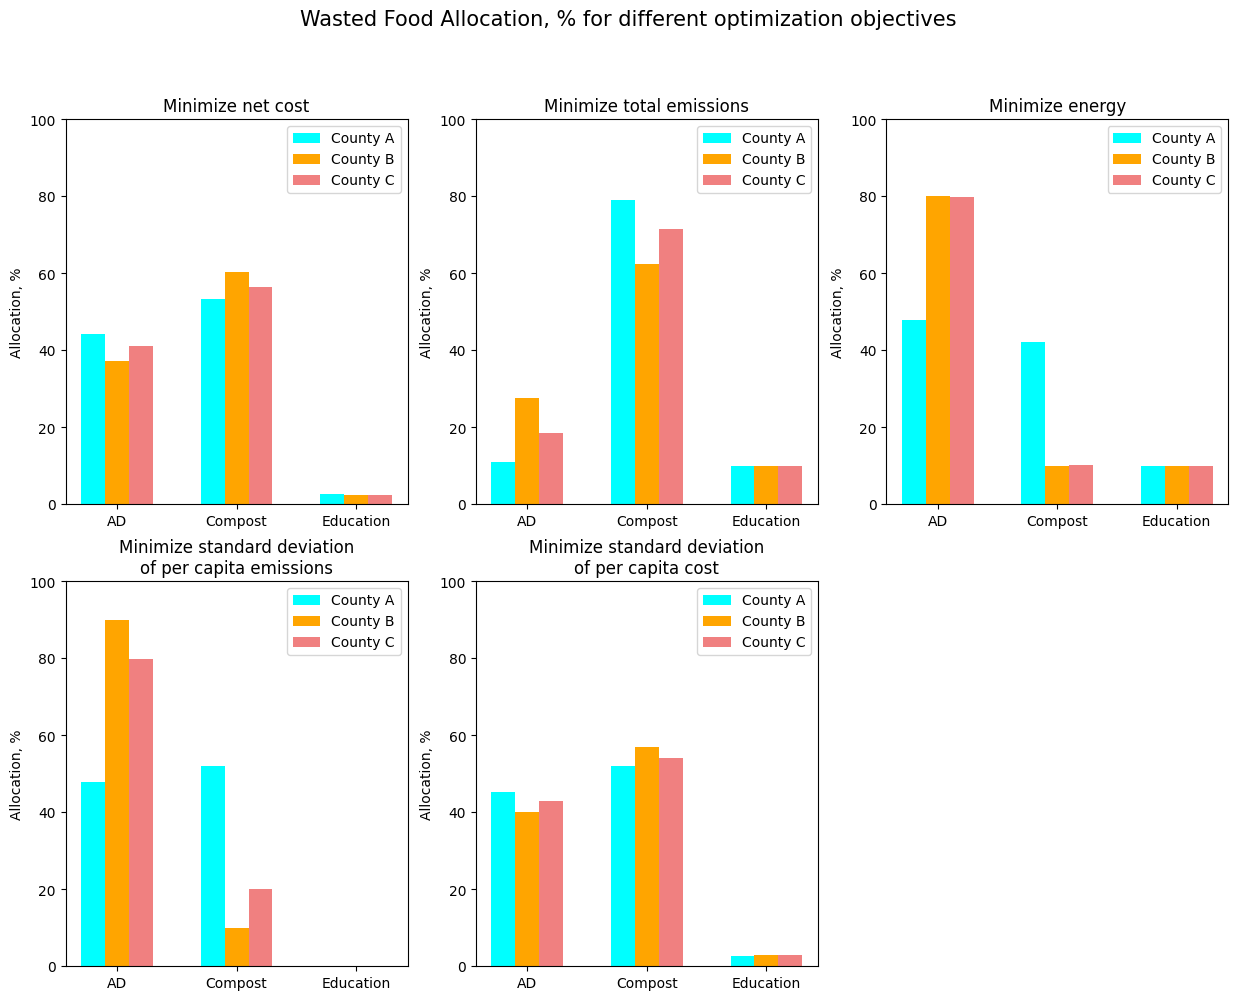

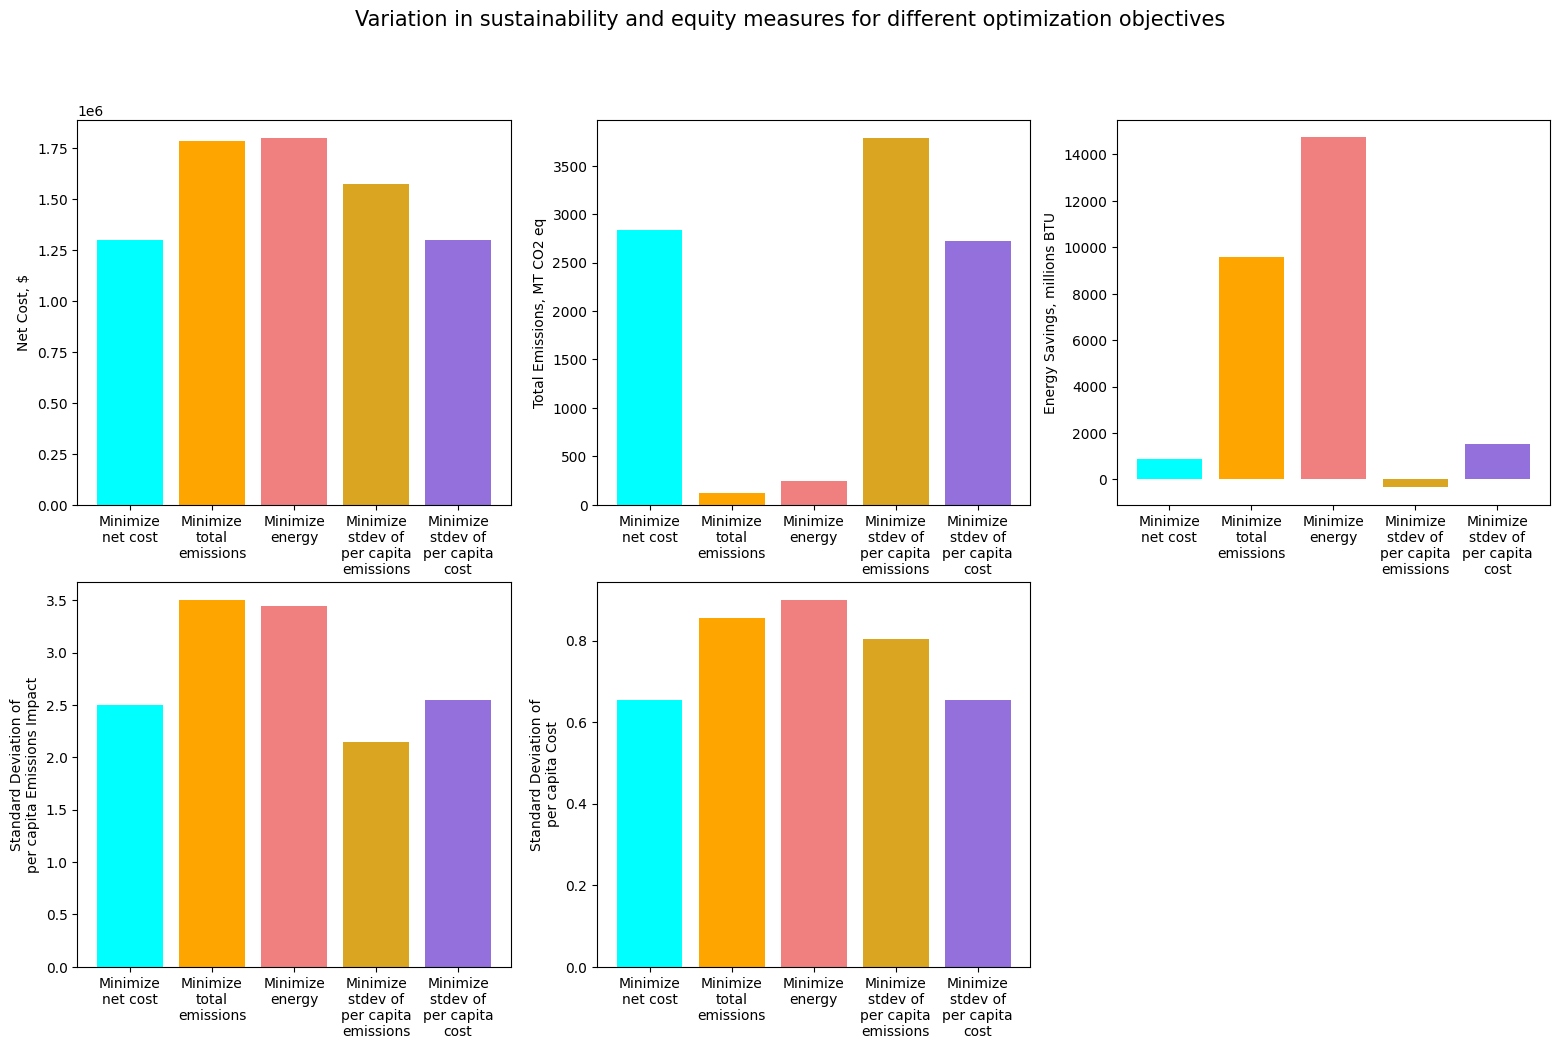

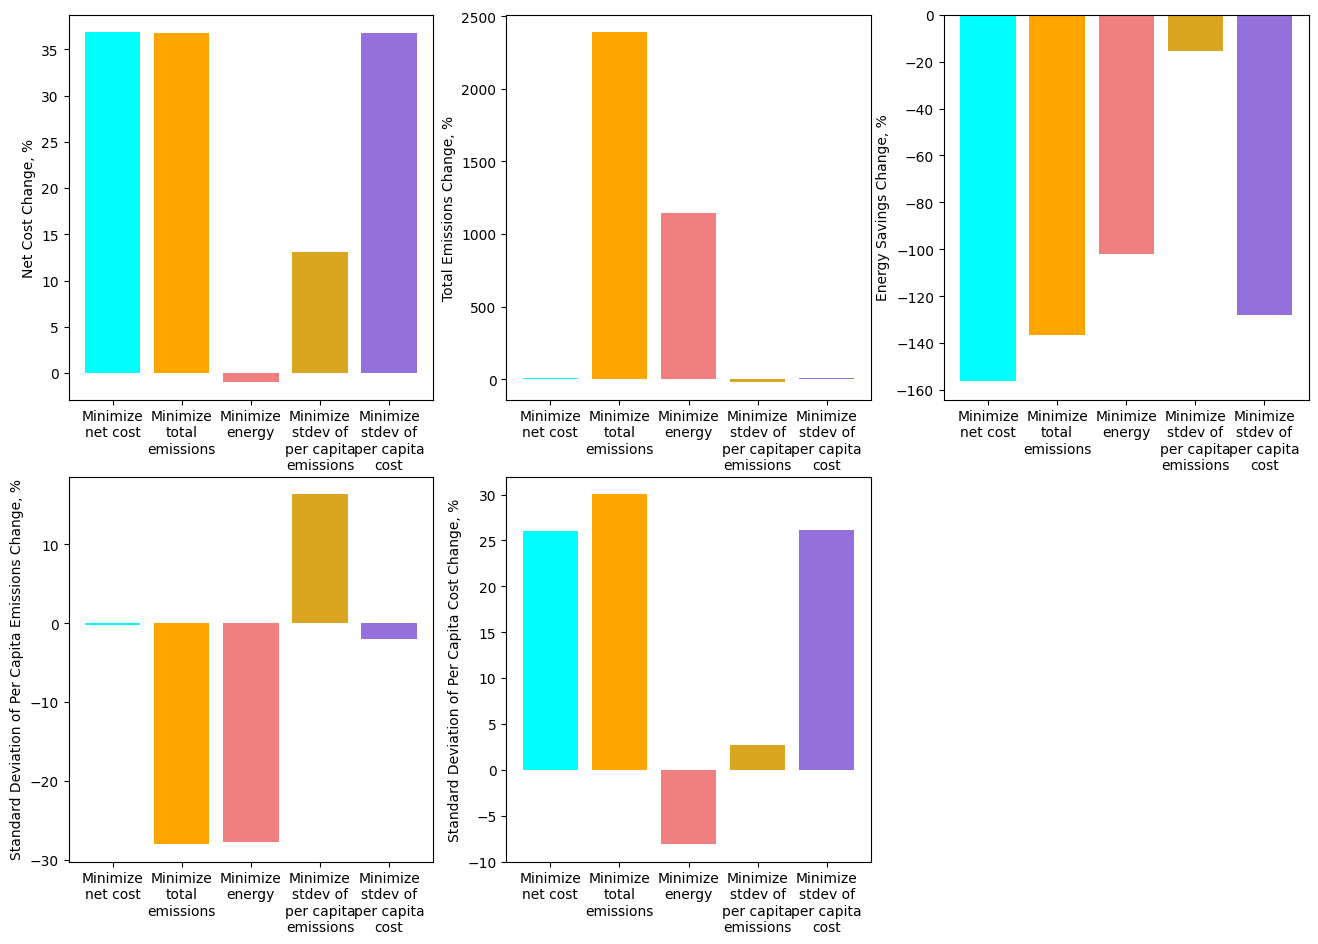

In [ ]:
x = np.arange(3)
County_A = [value(model_opt_net_cost.allocation['County A', 'AD'])*100, value(model_opt_net_cost.allocation['County A', 'Compost'])*100, value(model_opt_net_cost.allocation['County A', 'Education'])*100]
County_B = [value(model_opt_net_cost.allocation['County B', 'AD'])*100, value(model_opt_net_cost.allocation['County B', 'Compost'])*100, value(model_opt_net_cost.allocation['County B', 'Education'])*100]
County_C = [value(model_opt_net_cost.allocation['County C', 'AD'])*100, value(model_opt_net_cost.allocation['County C', 'Compost'])*100, value(model_opt_net_cost.allocation['County C', 'Education'])*100]

plt.figure(figsize=(15,11))

width = 0.20
plt.subplot(2, 3, 1)
plt.bar(x-0.2, County_A, width, color='cyan')
plt.bar(x+0.0, County_B, width, color='orange')
plt.bar(x+0.2, County_C, width, color='lightcoral')
plt.xticks(x, ['AD', 'Compost', 'Education'])
plt.ylabel("Allocation, %")
plt.legend(["County A", "County B", "County C"])
plt.title('Minimize net cost')
plt.ylim([0, 100])
############################################
x = np.arange(3)
County_A = [value(model_opt_sust_emis.allocation['County A', 'AD'])*100, value(model_opt_sust_emis.allocation['County A', 'Compost'])*100, value(model_opt_sust_emis.allocation['County A', 'Education'])*100]
County_B = [value(model_opt_sust_emis.allocation['County B', 'AD'])*100, value(model_opt_sust_emis.allocation['County B', 'Compost'])*100, value(model_opt_sust_emis.allocation['County B', 'Education'])*100]
County_C = [value(model_opt_sust_emis.allocation['County C', 'AD'])*100, value(model_opt_sust_emis.allocation['County C', 'Compost'])*100, value(model_opt_sust_emis.allocation['County C', 'Education'])*100]

width = 0.20
plt.subplot(2, 3, 2)
plt.bar(x-0.2, County_A, width, color='cyan')
plt.bar(x+0.0, County_B, width, color='orange')
plt.bar(x+0.2, County_C, width, color='lightcoral')
plt.xticks(x, ['AD', 'Compost', 'Education'])
plt.ylabel("Allocation, %")
plt.legend(["County A", "County B", "County C"])
plt.title('Minimize total emissions')
plt.ylim([0, 100])
###############################################
x = np.arange(3)
County_A = [value(model_opt_sust_energy.allocation['County A', 'AD'])*100, value(model_opt_sust_energy.allocation['County A', 'Compost'])*100, value(model_opt_sust_energy.allocation['County A', 'Education'])*100]
County_B = [value(model_opt_sust_energy.allocation['County B', 'AD'])*100, value(model_opt_sust_energy.allocation['County B', 'Compost'])*100, value(model_opt_sust_energy.allocation['County B', 'Education'])*100]
County_C = [value(model_opt_sust_energy.allocation['County C', 'AD'])*100, value(model_opt_sust_energy.allocation['County C', 'Compost'])*100, value(model_opt_sust_energy.allocation['County C', 'Education'])*100]

width = 0.20
plt.subplot(2, 3, 3)
plt.bar(x-0.2, County_A, width, color='cyan')
plt.bar(x+0.0, County_B, width, color='orange')
plt.bar(x+0.2, County_C, width, color='lightcoral')
plt.xticks(x, ['AD', 'Compost', 'Education'])
plt.ylabel("Allocation, %")
plt.legend(["County A", "County B", "County C"])
plt.title('Minimize energy')
plt.ylim([0, 100])
###############################################
x = np.arange(3)
County_A = [value(model_opt_stdv_emissions.allocation['County A', 'AD'])*100, value(model_opt_stdv_emissions.allocation['County A', 'Compost'])*100, value(model_opt_stdv_emissions.allocation['County A', 'Education'])*100]
County_B = [value(model_opt_stdv_emissions.allocation['County B', 'AD'])*100, value(model_opt_stdv_emissions.allocation['County B', 'Compost'])*100, value(model_opt_stdv_emissions.allocation['County B', 'Education'])*100]
County_C = [value(model_opt_stdv_emissions.allocation['County C', 'AD'])*100, value(model_opt_stdv_emissions.allocation['County C', 'Compost'])*100, value(model_opt_stdv_emissions.allocation['County C', 'Education'])*100]

width = 0.20
plt.subplot(2, 3, 4)
plt.bar(x-0.2, County_A, width, color='cyan')
plt.bar(x+0.0, County_B, width, color='orange')
plt.bar(x+0.2, County_C, width, color='lightcoral')
plt.xticks(x, ['AD', 'Compost', 'Education'])
plt.ylabel("Allocation, %")
plt.legend(["County A", "County B", "County C"])
plt.title('Minimize standard deviation\nof per capita emissions')
plt.ylim([0, 100])
###############################################
x = np.arange(3)
County_A = [value(model_opt_stdv_cost.allocation['County A', 'AD'])*100, value(model_opt_stdv_cost.allocation['County A', 'Compost'])*100, value(model_opt_stdv_cost.allocation['County A', 'Education'])*100]
County_B = [value(model_opt_stdv_cost.allocation['County B', 'AD'])*100, value(model_opt_stdv_cost.allocation['County B', 'Compost'])*100, value(model_opt_stdv_cost.allocation['County B', 'Education'])*100]
County_C = [value(model_opt_stdv_cost.allocation['County C', 'AD'])*100, value(model_opt_stdv_cost.allocation['County C', 'Compost'])*100, value(model_opt_stdv_cost.allocation['County C', 'Education'])*100]

width = 0.20
plt.subplot(2, 3, 5)
plt.bar(x-0.2, County_A, width, color='cyan')
plt.bar(x+0.0, County_B, width, color='orange')
plt.bar(x+0.2, County_C, width, color='lightcoral')
plt.xticks(x, ['AD', 'Compost', 'Education'])
plt.ylabel("Allocation, %")
plt.legend(["County A", "County B", "County C"])
plt.title('Minimize standard deviation\nof per capita cost')
plt.ylim([0, 100])
plt.suptitle('Wasted Food Allocation, % for different optimization objectives', fontsize=15)
plt.show()
print()
##################################################################################################################################
##################################################################################################################################
plt.figure(figsize=(19,11))

Optimization = ['Minimize\nnet cost', 'Minimize\ntotal\nemissions', 'Minimize\nenergy', 'Minimize\nstdev of\nper capita\nemissions', 'Minimize\nstdev of\nper capita\ncost']

plt.subplot(2, 3, 1)
NetCost = [model_opt_net_cost.Net_Cost_nc(), Net_Cost_susemis(), Net_Cost_susenr(), Net_Cost_sdemis(), Net_Cost_sdcst()]
plt.bar(Optimization, NetCost, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel("Net Cost, $")

plt.subplot(2, 3, 2)
TotalEmis = [Total_emissions_net_cost(), Total_emissions_sust_emis(), Total_emissions_sust_energy(),
             Total_emissions_stdv_emissions(), Total_emissions_stdv_cost()]
plt.bar(Optimization, TotalEmis, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel("Total Emissions, MT CO2 eq")

plt.subplot(2, 3, 3)
EnergySaving = [Net_energy_saving_net_cost(), Net_energy_saving_sust_emis(),
                Net_energy_saving_sust_energy(), Net_energy_saving_stdv_emissions(), Net_energy_saving_stdv_cost()]
plt.bar(Optimization, EnergySaving, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel("Energy Savings, millions BTU")

plt.subplot(2, 3, 4)
StdvEmiss = [sdv_emissions_net_cost(), sdv_emissions_sust_emis(), sdv_emissions_sust_energy(),
             model_opt_stdv_emissions.stdv_emissions(), sdv_emissions_stdv_cost()]
plt.bar(Optimization, StdvEmiss, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel("Standard Deviation of\nper capita Emissions Impact")

plt.subplot(2, 3, 5)
StdvCost = [sdv_cost_net_cost(), sdv_cost_sust_emis(), sdv_cost_sust_energy(), sdv_cost_stdv_emissions(), model_opt_stdv_cost.Std_deviation_cost()]
plt.bar(Optimization, StdvCost, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel("Standard Deviation of\nper capita Cost")
plt.suptitle('Variation in sustainability and equity measures for different optimization objectives', fontsize=15)
plt.show()
print()
##################################################################################################################################
##################################################################################################################################
Net_cost = {'Min net cost': model_opt_net_cost.Net_Cost_nc(), 'Min emissions': Net_Cost_susemis(), 'Min energy': Net_Cost_susenr(), 'Min stdv pc emis': Net_Cost_sdemis(), 'Min stdv pc cost': Net_Cost_sdcst()}
Total_emissions = {'Min net cost': Total_emissions_net_cost(), 'Min emissions': Total_emissions_sust_emis(), 'Min energy': Total_emissions_sust_energy(), 'Min stdv pc emis': Total_emissions_stdv_emissions(), 'Min stdv pc cost': Total_emissions_stdv_cost()}
Energy_savings = {'Min net cost': Net_energy_saving_net_cost(), 'Min emissions': Net_energy_saving_sust_emis(), 'Min energy': Net_energy_saving_sust_energy(), 'Min stdv pc emis': Net_energy_saving_stdv_emissions(), 'Min stdv pc cost': Net_energy_saving_stdv_cost()}
Stdv_pc_emis = {'Min net cost': sdv_emissions_net_cost(), 'Min emissions': sdv_emissions_sust_emis(), 'Min energy': sdv_emissions_sust_energy(), 'Min stdv pc emis': model_opt_stdv_emissions.stdv_emissions(), 'Min stdv pc cost': sdv_emissions_stdv_cost()}
Stdv_pc_cost = {'Min net cost': sdv_cost_net_cost(), 'Min emissions': sdv_cost_sust_emis(), 'Min energy': sdv_cost_sust_energy(), 'Min stdv pc emis': sdv_cost_stdv_emissions(), 'Min stdv pc cost': model_opt_stdv_cost.Std_deviation_cost()}

# Resilience
Net_cost_resil = {'Min net cost': model_opt_resil_net_cost.Net_Cost_rnc(), 'Min emissions': Net_cost_resi_sust_emis(), 'Min energy': Net_cost_resi_sust_energy(), 'Min stdv pc emis': Net_cost_resi_stdev_emiss(), 'Min stdv pc cost': Net_cost_resi_stdev_cost()}
Total_emissions_resil = {'Min net cost': Total_emissions_resi_net_cost(), 'Min emissions': Total_emissions_resi_sust_emis(), 'Min energy': Total_emissions_resi_sust_energy(), 'Min stdv pc emis': Total_emissions_resi_stdev_emiss(), 'Min stdv pc cost':  Total_emissions_resi_stdev_cost()}
Energy_savings_resil = {'Min net cost': Net_energy_saving_resi_net_cost(), 'Min emissions': Net_energy_saving_resi_sust_emis(), 'Min energy': Net_energy_saving_resi_sust_energy(), 'Min stdv pc emis': Net_energy_saving_resi_stdev_emiss(), 'Min stdv pc cost': Net_energy_saving_resi_stdev_cost()}
Stdv_pc_emis_resil = {'Min net cost': sdv_emissions_resi_net_cost(), 'Min emissions':sdv_emissions_resi_sust_emis(), 'Min energy': sdv_emissions_resi_sust_energy(), 'Min stdv pc emis': model_opt_resil_stdev_emiss.resil_stdev_emiss(), 'Min stdv pc cost': sdv_emissions_resi_stdev_cost()}
Stdv_pc_cost_resil = {'Min net cost': sdv_cost_resi_net_cost(), 'Min emissions': sdv_cost_resi_sust_emis(), 'Min energy': sdv_cost_resi_sust_energy(), 'Min stdv pc emis': sdv_cost_resi_stdev_emiss(), 'Min stdv pc cost': model_opt_resil_stdev_cost.resil_stdev_cost()}

Net_cost_change = {}
for i in Net_cost:
  Net_cost_change[i] = (Net_cost_resil[i] - Net_cost[i])*100/Net_cost[i]
Total_emissions_change = {}
for i in Net_cost:
  Total_emissions_change[i] = (Total_emissions_resil[i] - Total_emissions[i])*100/Total_emissions[i]
Energy_savings_change = {}
for i in Energy_savings:
  Energy_savings_change[i] = (Energy_savings_resil[i] - Energy_savings[i])*100/Energy_savings[i]
Stdv_pc_emis_change = {}
for i in Stdv_pc_emis:
  Stdv_pc_emis_change[i] = (Stdv_pc_emis_resil[i] - Stdv_pc_emis[i])*100/Stdv_pc_emis[i]
Stdv_pc_cost_change = {}
for i in Stdv_pc_cost:
  Stdv_pc_cost_change[i] = (Stdv_pc_cost_resil[i] - Stdv_pc_cost[i])*100/Stdv_pc_cost[i]

plt.figure(figsize=(16,11))
plt.subplot(2, 3, 1)
values_1 = list(Net_cost_change.values())
plt.bar(Optimization, values_1, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel('Net Cost Change, %')

plt.subplot(2, 3, 2)
values_2 = list(Total_emissions_change.values())
plt.bar(Optimization, values_2, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel('Total Emissions Change, %')

plt.subplot(2, 3, 3)
values_3 = list(Energy_savings_change.values())
plt.bar(Optimization, values_3, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel('Energy Savings Change, %')

plt.subplot(2, 3, 4)
values_4 = list(Stdv_pc_emis_change.values())
plt.bar(Optimization, values_4, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel('Standard Deviation of Per Capita Emissions Change, %')

plt.subplot(2, 3, 5)
values_5 = list(Stdv_pc_cost_change.values())
plt.bar(Optimization, values_5, color=['cyan', 'orange', 'lightcoral', 'goldenrod', 'mediumpurple'])
plt.ylabel('Standard Deviation of Per Capita Cost Change, %')
#plt.suptitle('Percentage change in cost, sustainability and equity measures', fontsize=15)
plt.show()
